**The second Jupyter Notebook focuses on performing extrinsic analysis on OpenStreetMap (OSM) data and with official bicycle network data from the Austrian GIP data. The goal of these evaluations is to compare the two datasets and evaluate its quality. All evaluations are inspired by previous studies on quality assessment of Volunteered Geographic Information (VGI). Like the first notebook, this notebook also classifies OSM and GIP line features into three infrastructure classes.**

**The notebook is divided into two main sections. P1 - P4 is for data preparation and setting up the environment. E1 - E7 represents several quality analysis sections.**

# P1: Import Libraries

In [1]:
try:
    import google.colab
    import os

    # Clone the repository
    if not os.path.exists("/content/osm-bike-analysis"):
        !git clone https://github.com/marcelharing/osm-bike-analysis.git
        pass

    # Change the working directory
    %cd osm-bike-analysis

    # Install dependencies
    !pip --quiet install -r requirements.txt

    # Google Colab saves files in an folder named content
    diskpath = os.getcwd()
    
except ImportError:
    diskpath = '.' # relative file path

In [2]:
# Import libraries
import osmnx
import os
import codecs
import osm2geojson
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime as dt
import folium
from folium.plugins import ScrollZoomToggler
from folium.plugins import DualMap 
from folium.plugins import GroupedLayerControl
import ipywidgets as widgets
import requests
import zipfile
import os
import numpy as np
import pyogrio
import xyzservices.providers as xyz
import networkx as nx
import random
import plotly.graph_objects as go
import plotly.express as px
from shapely.geometry import LineString, Point
import branca.colormap as cm
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import contextily as cx
from xyzservices import TileProvider


from functions import * 
from download_functions import *

In [3]:
#### STYLE CONFIGURATION ####

# Define Folium layers for leaflet maps

basemapat = xyz.BasemapAT.highdpi(name="BasemapAT", max_zoom=21)
esri = xyz.Esri.WorldImagery(max_zoom=21)
cyclosm = xyz.CyclOSM(max_zoom=21)


thunderforestatlas = TileProvider(
    {
        "url": "https://tile.thunderforest.com/atlas/{z}/{x}/{y}.png?apikey={accessToken}",
        "attribution": "thunderforest.com, Data OSM Contributors",
        "accessToken": "3ad11fafa2564c1183c66f15224857b5",
        "name": "OSM TF Atlas",
        "max_zoom": 21,
    }
)

opencyclemap = TileProvider(
    {
        "url": "https://tile.thunderforest.com/cycle/{z}/{x}/{y}.png?apikey={accessToken}",
        "attribution": "thunderforest.com, Data OSM Contributors",
        "accessToken": "3ad11fafa2564c1183c66f15224857b5",
        "name": "OpenCycleMap",
        "max_zoom": 21,
    }
)


# Define color palette
color_osm = "#00debc"
color_gip = "#5f0038"

color_cycle_tracks = "#0a007b"
color_cycle_lanes = "#006bff"
color_calm_traffic_ways = "#c63ddb"
color_total = "#1c1c1c"
color_turnuse = "grey"

# P2: Study area and Parameters
⏩You can choose any **administrative boundary** (for examples cities, regions) which have a relation in OSM. Search for it like in [Nominatim](https://nominatim.openstreetmap.org/ui/search.html), for example: *Innsbruck, Austria*

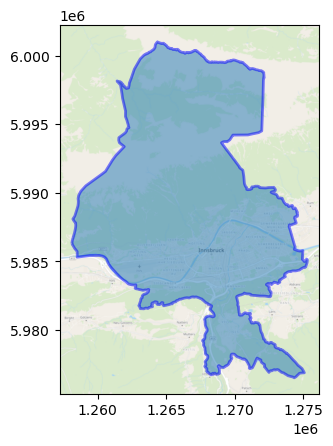

In [4]:
nominatim_area = input("Please enter the city, town or region you want to analyze: ")

# Nominatim query
gdf_area = osmnx.geocode_to_gdf(nominatim_area)

# Plot the area
f, ax = plt.subplots()
gdf_area.to_crs(epsg=3857).plot(ax=ax, alpha=0.5, edgecolor="b", linewidth=2) # EPSG 3857 = Web Mercator
cx.add_basemap(
    ax,
    source="https://tile.thunderforest.com/atlas/{z}/{x}/{y}.png?apikey=3ad11fafa2564c1183c66f15224857b5",
)

# Get the area as a GEOJSON file
gjson_area = gdf_area.to_json()
# areaID is always osm_id + 3600000000, has to be a relation, gdf_area.osm_id comes from osmnx nominatim query above
areaId = gdf_area.osm_id[0] + 3600000000

# Calculate the bounding box of the geometries
x_min, y_min, x_max, y_max = gdf_area.geometry.total_bounds

# Calculate the center of the bounding box for folium map starting position
folium_start_pos_x = (x_min + x_max) / 2
folium_start_pos_y = (y_min + y_max) / 2

⏩ Optionally, you can enter the EPSG Code (in format *EPSG:4258*) for your prefered **Coordinate Reference System**, but it is recommended to leave it as it is because the best CRS is selected automatically (in UTM CRS). If you really want to choose your own CRS, **be aware that the units depend on the units of your CRS**. It is strongly recommended that if you're using your own CRS, you are selecting one with metres as unit so that the calculations and evaluations are correct.

In [5]:
crs = ""

if not crs:
    # Project area with OSMNX automatically and take CRS attribute if no CRS is given
    gdf_area_crs = osmnx.projection.project_gdf(gdf_area)
    crs = gdf_area_crs.crs
else:
    # Grid to own CRS
    gdf_area_crs = osmnx.projection.project_gdf(gdf_area, to_crs=crs)
    crs = gdf_area_crs.crs

# P3: Load and Preprocess OSM Data

## Overpass Queries

Overpass is a web API that allows users to get and **filter specific OSM features**. It has its own [query language](https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL).

All queries are already defined and nothing needs to be done anymore. But if you want to analyse **your own set of OSM attributes** (for example, all one-way streets where bicycles can also travel against the one-way traffic flow), you can define and analyse your own infrastructure class.  You can use the Overpass [Turbo Wizard](https://overpass-turbo.eu/) to do this. However, the query output should be in XML format `[out:xml] ` and return also metadata `out meta;` so it should look like this:
```[out:xml][timeout:200];
area(id:{areaId})->.searchArea;
(
  FEATURES SETS HERE
);
(._;>;);
out meta;
```



In [6]:
#### OVERPASS QUERYS ####

### CYCLE LANES ###
query_cycletracks = f"""
/*
“(highway=cycleway   OR (highway=path OR highway= footway) AND (bicycle=designated OR bicycle=yes OR bicycle=permissive)  OR (cycleway=track OR cycleway=opposite_track)  OR (cycleway:right=track OR cycleway:right=opposite_track)  OR (cycleway:left=track OR cycleway:left=opposite_track)  OR (cycleway:both=track OR cycleway:both=opposite_track) ) in Innsbruck”
*/
[out:xml][timeout:200];
area(id:{areaId})->.searchArea;
(
  way["highway"="cycleway"](area.searchArea);
  way["highway"="path"]["bicycle"="designated"](area.searchArea);
  way["highway"="path"]["bicycle"="yes"](area.searchArea);
  way["highway"="path"]["bicycle"="permissive"](area.searchArea);
  way["highway"="footway"]["bicycle"="designated"](area.searchArea);
  way["highway"="footway"]["bicycle"="yes"](area.searchArea);
  way["highway"="footway"]["bicycle"="permissive"](area.searchArea);
  way["cycleway"="track"](area.searchArea);
  way["cycleway"="opposite_track"](area.searchArea);
  way["cycleway:right"="track"](area.searchArea);
  way["cycleway:right"="opposite_track"](area.searchArea);
  way["cycleway:left"="track"](area.searchArea);
  way["cycleway:left"="opposite_track"](area.searchArea);
  way["cycleway:both"="track"](area.searchArea);
  way["cycleway:both"="opposite_track"](area.searchArea);
);
(._;>;);
out meta;
"""
### CYCLE LANES ###
query_cyclelanes= f"""
/*
“(cycleway=lane OR cycleway=opposite_lane) OR (cycleway:right=lane OR cycleway:right=opposite_lane) OR (cycleway:left=lane OR cycleway:left=opposite_lane) OR (cycleway:both=lane OR cycleway:both=opposite_lane) in Innsbruck”
*/
[out:xml][timeout:200];
area(id:{areaId})->.searchArea;
(
  way["cycleway"="lane"](area.searchArea);
  way["cycleway"="opposite_lane"](area.searchArea);
  way["cycleway:right"="lane"](area.searchArea);
  way["cycleway:right"="opposite_lane"](area.searchArea);
  way["cycleway:left"="lane"](area.searchArea);
  way["cycleway:left"="opposite_lane"](area.searchArea);
  way["cycleway:both"="lane"](area.searchArea);
  way["cycleway:both"="opposite_lane"](area.searchArea);
);
(._;>;);
out meta;
"""

### CALM TRAFFIC WAYS ####
query_calmtrafficways= f"""
/*
The original search was:
“(  (highway=track OR highway=service OR highway=unclassified OR highway=residential) AND bicycle!=* AND (motor_vehicle=private OR motor_vehicle=no OR motor_vehicle=customers OR motor_vehicle=agricultural OR motor_vehicle=forestry OR motor_vehicle=destination OR motor_vehicle=delivery) ) OR  (  (highway=track OR highway=service OR highway=unclassified OR highway=residential) AND ( (motor_vehicle=private OR motor_vehicle=no OR motor_vehicle=customers OR motor_vehicle=agricultural OR motor_vehicle=forestry OR motor_vehicle=destination OR motor_vehicle=delivery) OR (access=private OR access=no OR access=customers OR access=agricultural OR access=forestry OR access=destination OR access=delivery) OR (vehicle=private OR vehicle=no OR vehicle=customers OR vehicle=agricultural OR vehicle=forestry OR vehicle=destination OR vehicle=delivery) ) AND (bicycle=designated OR bicycle=yes OR bicycle=permissive) ) OR ( highway=track  AND (bicycle=designated OR bicycle=yes OR bicycle=permissive) AND (motor_vehicle!=* AND access!=* AND vehicle!=*) ) OR ( highway=living_street ) OR ( bicycle_road=yes ) OR ( highway=pedestrian  AND (bicycle=designated OR bicycle=yes OR bicycle=permissive) )”
*/
[out:xml][timeout:240];
area(id:{areaId})->.searchArea;
(
way["highway"="track"]["bicycle"!~".*"]["motor_vehicle"="private"](area.searchArea);
way["highway"="track"]["bicycle"!~".*"]["motor_vehicle"="no"](area.searchArea);
way["highway"="track"]["bicycle"!~".*"]["motor_vehicle"="customers"](area.searchArea);
way["highway"="track"]["bicycle"!~".*"]["motor_vehicle"="agricultural"](area.searchArea);
way["highway"="track"]["bicycle"!~".*"]["motor_vehicle"="forestry"](area.searchArea);
way["highway"="track"]["bicycle"!~".*"]["motor_vehicle"="destination"](area.searchArea);
way["highway"="track"]["bicycle"!~".*"]["motor_vehicle"="delivery"](area.searchArea);
way["highway"="service"]["bicycle"!~".*"]["motor_vehicle"="private"](area.searchArea);
way["highway"="service"]["bicycle"!~".*"]["motor_vehicle"="no"](area.searchArea);
way["highway"="service"]["bicycle"!~".*"]["motor_vehicle"="customers"](area.searchArea);
way["highway"="service"]["bicycle"!~".*"]["motor_vehicle"="agricultural"](area.searchArea);
way["highway"="service"]["bicycle"!~".*"]["motor_vehicle"="forestry"](area.searchArea);
way["highway"="service"]["bicycle"!~".*"]["motor_vehicle"="destination"](area.searchArea);
way["highway"="service"]["bicycle"!~".*"]["motor_vehicle"="delivery"](area.searchArea);
way["highway"="unclassified"]["bicycle"!~".*"]["motor_vehicle"="private"](area.searchArea);
way["highway"="unclassified"]["bicycle"!~".*"]["motor_vehicle"="no"](area.searchArea);
way["highway"="unclassified"]["bicycle"!~".*"]["motor_vehicle"="customers"](area.searchArea);
way["highway"="unclassified"]["bicycle"!~".*"]["motor_vehicle"="agricultural"](area.searchArea);
way["highway"="unclassified"]["bicycle"!~".*"]["motor_vehicle"="forestry"](area.searchArea);
way["highway"="unclassified"]["bicycle"!~".*"]["motor_vehicle"="destination"](area.searchArea);
way["highway"="unclassified"]["bicycle"!~".*"]["motor_vehicle"="delivery"](area.searchArea);
way["highway"="residential"]["bicycle"!~".*"]["motor_vehicle"="private"](area.searchArea);
way["highway"="residential"]["bicycle"!~".*"]["motor_vehicle"="no"](area.searchArea);
way["highway"="residential"]["bicycle"!~".*"]["motor_vehicle"="customers"](area.searchArea);
way["highway"="residential"]["bicycle"!~".*"]["motor_vehicle"="agricultural"](area.searchArea);
way["highway"="residential"]["bicycle"!~".*"]["motor_vehicle"="forestry"](area.searchArea);
way["highway"="residential"]["bicycle"!~".*"]["motor_vehicle"="destination"](area.searchArea);
way["highway"="residential"]["bicycle"!~".*"]["motor_vehicle"="delivery"](area.searchArea);
way["highway"="track"]["motor_vehicle"="private"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["motor_vehicle"="private"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["motor_vehicle"="private"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["motor_vehicle"="no"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["motor_vehicle"="no"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["motor_vehicle"="no"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["motor_vehicle"="customers"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["motor_vehicle"="customers"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["motor_vehicle"="customers"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["motor_vehicle"="agricultural"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["motor_vehicle"="agricultural"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["motor_vehicle"="agricultural"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["motor_vehicle"="forestry"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["motor_vehicle"="forestry"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["motor_vehicle"="forestry"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["motor_vehicle"="destination"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["motor_vehicle"="destination"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["motor_vehicle"="destination"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["motor_vehicle"="delivery"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["motor_vehicle"="delivery"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["motor_vehicle"="delivery"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["access"="private"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["access"="private"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["access"="private"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["access"="no"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["access"="no"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["access"="no"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["access"="customers"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["access"="customers"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["access"="customers"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["access"="agricultural"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["access"="agricultural"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["access"="agricultural"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["access"="forestry"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["access"="forestry"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["access"="forestry"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["access"="destination"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["access"="destination"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["access"="destination"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["access"="delivery"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["access"="delivery"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["access"="delivery"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["vehicle"="private"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["vehicle"="private"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["vehicle"="private"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["vehicle"="no"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["vehicle"="no"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["vehicle"="no"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["vehicle"="customers"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["vehicle"="customers"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["vehicle"="customers"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["vehicle"="agricultural"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["vehicle"="agricultural"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["vehicle"="agricultural"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["vehicle"="forestry"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["vehicle"="forestry"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["vehicle"="forestry"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["vehicle"="destination"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["vehicle"="destination"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["vehicle"="destination"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["vehicle"="delivery"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["vehicle"="delivery"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["vehicle"="delivery"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["motor_vehicle"="private"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["motor_vehicle"="private"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["motor_vehicle"="private"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["motor_vehicle"="no"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["motor_vehicle"="no"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["motor_vehicle"="no"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["motor_vehicle"="customers"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["motor_vehicle"="customers"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["motor_vehicle"="customers"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["motor_vehicle"="agricultural"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["motor_vehicle"="agricultural"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["motor_vehicle"="agricultural"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["motor_vehicle"="forestry"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["motor_vehicle"="forestry"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["motor_vehicle"="forestry"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["motor_vehicle"="destination"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["motor_vehicle"="destination"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["motor_vehicle"="destination"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["motor_vehicle"="delivery"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["motor_vehicle"="delivery"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["motor_vehicle"="delivery"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["access"="private"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["access"="private"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["access"="private"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["access"="no"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["access"="no"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["access"="no"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["access"="customers"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["access"="customers"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["access"="customers"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["access"="agricultural"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["access"="agricultural"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["access"="agricultural"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["access"="forestry"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["access"="forestry"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["access"="forestry"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["access"="destination"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["access"="destination"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["access"="destination"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["access"="delivery"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["access"="delivery"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["access"="delivery"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["vehicle"="private"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["vehicle"="private"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["vehicle"="private"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["vehicle"="no"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["vehicle"="no"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["vehicle"="no"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["vehicle"="customers"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["vehicle"="customers"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["vehicle"="customers"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["vehicle"="agricultural"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["vehicle"="agricultural"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["vehicle"="agricultural"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["vehicle"="forestry"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["vehicle"="forestry"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["vehicle"="forestry"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["vehicle"="destination"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["vehicle"="destination"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["vehicle"="destination"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["vehicle"="delivery"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["vehicle"="delivery"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["vehicle"="delivery"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="private"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="private"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="private"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="no"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="no"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="no"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="customers"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="customers"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="customers"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="agricultural"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="agricultural"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="agricultural"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="forestry"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="forestry"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="forestry"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="destination"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="destination"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="destination"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="delivery"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="delivery"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="delivery"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["access"="private"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["access"="private"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["access"="private"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["access"="no"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["access"="no"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["access"="no"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["access"="customers"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["access"="customers"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["access"="customers"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["access"="agricultural"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["access"="agricultural"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["access"="agricultural"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["access"="forestry"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["access"="forestry"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["access"="forestry"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["access"="destination"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["access"="destination"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["access"="destination"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["access"="delivery"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["access"="delivery"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["access"="delivery"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["vehicle"="private"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["vehicle"="private"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["vehicle"="private"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["vehicle"="no"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["vehicle"="no"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["vehicle"="no"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["vehicle"="customers"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["vehicle"="customers"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["vehicle"="customers"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["vehicle"="agricultural"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["vehicle"="agricultural"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["vehicle"="agricultural"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["vehicle"="forestry"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["vehicle"="forestry"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["vehicle"="forestry"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["vehicle"="destination"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["vehicle"="destination"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["vehicle"="destination"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["vehicle"="delivery"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["vehicle"="delivery"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["vehicle"="delivery"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="private"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="private"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="private"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="no"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="no"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="no"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="customers"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="customers"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="customers"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="agricultural"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="agricultural"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="agricultural"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="forestry"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="forestry"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="forestry"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="destination"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="destination"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="destination"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="delivery"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="delivery"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="delivery"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["access"="private"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["access"="private"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["access"="private"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["access"="no"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["access"="no"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["access"="no"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["access"="customers"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["access"="customers"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["access"="customers"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["access"="agricultural"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["access"="agricultural"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["access"="agricultural"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["access"="forestry"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["access"="forestry"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["access"="forestry"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["access"="destination"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["access"="destination"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["access"="destination"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["access"="delivery"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["access"="delivery"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["access"="delivery"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["vehicle"="private"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["vehicle"="private"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["vehicle"="private"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["vehicle"="no"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["vehicle"="no"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["vehicle"="no"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["vehicle"="customers"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["vehicle"="customers"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["vehicle"="customers"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["vehicle"="agricultural"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["vehicle"="agricultural"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["vehicle"="agricultural"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["vehicle"="forestry"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["vehicle"="forestry"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["vehicle"="forestry"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["vehicle"="destination"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["vehicle"="destination"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["vehicle"="destination"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["vehicle"="delivery"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["vehicle"="delivery"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["vehicle"="delivery"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["bicycle"="designated"]["motor_vehicle"!~".*"]["access"!~".*"]["vehicle"!~".*"](area.searchArea);
way["highway"="track"]["bicycle"="yes"]["motor_vehicle"!~".*"]["access"!~".*"]["vehicle"!~".*"](area.searchArea);
way["highway"="track"]["bicycle"="permissive"]["motor_vehicle"!~".*"]["access"!~".*"]["vehicle"!~".*"](area.searchArea);
way["highway"="living_street"]["area"!="yes"](area.searchArea);
way["bicycle_road"="yes"](area.searchArea);
way["highway"="pedestrian"]["bicycle"="designated"]["area"!="yes"](area.searchArea);
way["highway"="pedestrian"]["bicycle"="yes"]["area"!="yes"](area.searchArea);
way["highway"="pedestrian"]["bicycle"="permissive"]["area"!="yes"](area.searchArea);
);
(._;>;);
out meta;
"""

## Download OSM Data

The data is retrieved from OSM using the Overpass API and the appropriate queries. 

A graph (based on the module OSMNX and NetworkX) is also created from the data, which is used for topological evaluations. In this notebook these are the Dangling Nodes Analysis (E2), Components Analysis (E3) and Missing Links Analysis. For all other analyses, a GeoPandas GeoDataFrame is used.

In [7]:
"""
A dictionary with all data for each infrastructure class is created.
The dictionary for each 'infr_class' can contains the following elements:

- 'query': The query statement to retrieve data.
- 'name': The name of the infrastructure class.
- 'graph': Routable directed OSMNX graph. 
  This graph is routable and represents the infrastructure in both directions (i.e. edges are bidirectional). 
  It is projected and clipped to the study area (i.e. all nodes except the first one outside the study area of an edge are removed). 
  Note that the bidirectional graphs edge directions are based on regular vehicle traffic (e.g. one way streets for cars are only represented as one edge instead of two). 
  To analyse bicycle traffic, it is important to convert and use an undirected graph.
- 'gdf_xml': A separate GeoDataFrame directly from the XML file. 
  This GeoDataFrame includes 'version' and 'timestamp' columns, which are part of the Overpass API's meta output. 
  Note that OSMNX does not provide this metadata. However, the XML-derived GeoDataFrame is not routable and contains the original number of OSM features. 
  If there are no features, an empty GDF is created. 
  It is projected and clipped to the study area directly where the study area polygon intersects the features with a buffer tolerance of 1.5m.
"""

dict_osm_cycle_tracks = {
    "query": query_cycletracks,
    "name": "cycle_tracks",
    "graph": "",
}
dict_osm_cycle_lanes = {
    "query": query_cyclelanes, 
    "name": "cycle_lanes", 
    "graph": ""
  }
dict_osm_calm_traffic_ways = {
    "query": query_calmtrafficways,
    "name": "calm_traffic_ways",
    "graph": "",
    "gdf_xml": "",
}
ls_classes = [dict_osm_cycle_tracks, dict_osm_cycle_lanes, dict_osm_calm_traffic_ways]

# Set useful tags to add them to the osmnx graph for further evaluations
osmnx.settings.useful_tags_way += [
    "lane",
    "track",
    "opposite_track",
    "opposite_lane",
    "cycleway",
    "cycleway:right",
    "cycleway:left",
    "cycleway:both",
]

# Call Overpass API, built a OSMNX graph and a GeoDataFrame and update the dictionary with 'to_data_dict'
ls_classes = to_data_dict(
    ls_classes=ls_classes,
    area_name=nominatim_area,
    diskpath=diskpath,
    clip=True,
    crs=crs,
    gdf_area=gdf_area_crs,
)

In [8]:
"""
Additionally a dictionary for all infr_classes together (total amount of features) is created, it contains the following elements:

- 'name': The name of the infrastructure class.
- 'graph': Routable directed OSMNX graph. 
  This graph is routable and represents the infrastructure in both directions (i.e. edges are bidirectional). 
  It is projected and clipped to the study area (i.e. all nodes except the first one outside the study area of an edge are removed). 
  Note that the bidirectional graphs edge directions are based on regular vehicle traffic (e.g. one way streets for cars are only represented as one edge instead of two). 
  To analyse bicycle traffic, it is important to convert and use an undirected graph.
- 'gdf_xml': A separate GeoDataFrame directly from the XML file. 
  This GeoDataFrame includes 'version' and 'timestamp' columns, which are part of the Overpass API's meta output. 
  Note that OSMNX does not provide this metadata. However, the XML-derived GeoDataFrame is not routable and contains the original number of OSM features. 
  If there are no features, an empty GDF is created. 
  It is projected and clipped to the study area directly where the study area polygon intersects the features with a buffer tolerance of 1.5m.
- 'gdf_xml_dt': same as gdf_xml but with datetime objects; folium can't handle datetime objects so there is a own gdf
"""

dict_osm_total = {
    "name": "Total Bicycle Infrastructure",
    "graph": "",
    "gdf_xml": "",
    "gdf_xml_dt": "",
}

# Create a list of non-empty MultiDiGraphs created in the section above
Gs = [
    dict_osm_cycle_tracks["graph"],
    dict_osm_cycle_lanes["graph"],
    dict_osm_calm_traffic_ways["graph"],
]
Gs_valid = [x for x in Gs if x]  # only non-empty graphs allowed

#### Graph ####
# Combine the Graphs together into one if Gs_valid is not empty
if Gs_valid:
    dict_osm_total["graph"] = nx.compose_all(Gs_valid)
else:
    raise ValueError("NO INFRASTRUCTURE IN YOUR STUDY AREA. STOPPING SCRIPT.")

#### GDF XML ####
# New column with infrastructure class to distinguish infr_classes in total gdf
dict_osm_cycle_tracks["gdf_xml"]["infr_class"] = "Cycle Tracks"
dict_osm_cycle_lanes["gdf_xml"]["infr_class"] = "Cycle Lanes"
dict_osm_calm_traffic_ways["gdf_xml"]["infr_class"] = "Calm Traffic Ways"

# Combine all classes in one GDF
dict_osm_total["gdf_xml"] = gpd.GeoDataFrame(
    pd.concat(
        [df for df in [dict_osm_cycle_tracks["gdf_xml"], 
                       dict_osm_cycle_lanes["gdf_xml"], 
                       dict_osm_calm_traffic_ways["gdf_xml"]] if not df.empty],
        ignore_index=True,
    ),
    crs=[dict_osm_cycle_tracks["gdf_xml"], dict_osm_cycle_lanes["gdf_xml"]][0].crs,
)

#### GDF XML DT ####
# Convert timestamp to datetime object in a new gdf because folium can't handle datetime objects
dict_osm_total["gdf_xml_dt"] = dict_osm_total["gdf_xml"].copy()
# Convert timestamp to date
dict_osm_total["gdf_xml_dt"].timestamp = pd.to_datetime(
    dict_osm_total["gdf_xml_dt"].timestamp
)

Convert possible MultiLinestrings and Polygons into LineStrings and drop geometries other than Linestring.

Also, in some rare cases, there can be duplicates. This is the case when a LineString is classified in more than one infrastructure class (for example, because a street is a calm traffic way and has in addition cycle lanes).

In [9]:
# Convert possible MultiLineStrings and Polygons to LineStrings at the XML (non graph) GeoDataFrames
# The graph should be processed by OSMNX correctly
dict_osm_total["gdf_xml"] = to_linestring(dict_osm_total["gdf_xml"])
dict_osm_total["gdf_xml_dt"] = to_linestring(dict_osm_total["gdf_xml_dt"])

dict_osm_cycle_tracks["gdf_xml"] = to_linestring(dict_osm_cycle_tracks["gdf_xml"])
dict_osm_cycle_lanes["gdf_xml"] = to_linestring(dict_osm_cycle_lanes["gdf_xml"])
dict_osm_calm_traffic_ways["gdf_xml"] = to_linestring(
    dict_osm_calm_traffic_ways["gdf_xml"]
)

# Drop duplicates in the GeoDataFrames
if dict_osm_total["gdf_xml"].duplicated("geometry").any():
    print("Duplicates in GeodataFrame dropped.")

dict_osm_total["gdf_xml"].drop_duplicates(
    subset="geometry", keep="first", inplace=True
)
dict_osm_total["gdf_xml_dt"].drop_duplicates(
    subset="geometry", keep="first", inplace=True
)

Duplicates in GeodataFrame dropped.


## Infrastructure Length vs. Geometry Length

<img src="https://i.imgur.com/kxSkubZ.png" alt="drawing" width="400"/>

In OSM, bicycle infrastructure can be mapped with its own geometry or with attributes on main roads. In the CycleOSM image above, the cycle track in the park has its own geometry, and the cycle track on the road from west to east is attached to the road geometry.

If a main road has two cycle lanes or cycle tracks (one per direction), both will use the same geometry. This means that based on the attributes, the actual cycle infrastructure length can be twice as long as the geometry length. For more information see [cycle lanes](https://wiki.openstreetmap.org/wiki/Tag:cycleway%3Dlane) and [cycle tracks](https://wiki.openstreetmap.org/wiki/Tag:cycleway%3Dtrack) on the OSM wiki.


In [10]:
# Calculate the length of the geometry
dict_osm_total["gdf_xml"]["geom_length"] = dict_osm_total[
    "gdf_xml_dt"
].geometry.length
dict_osm_cycle_tracks["gdf_xml"]["geom_length"] = dict_osm_cycle_tracks[
    "gdf_xml"
].geometry.length
dict_osm_cycle_lanes["gdf_xml"]["geom_length"] = dict_osm_cycle_lanes[
    "gdf_xml"
].geometry.length
dict_osm_calm_traffic_ways["gdf_xml"]["geom_length"] = dict_osm_calm_traffic_ways[
    "gdf_xml"
].geometry.length

# Calculate 'infr_length' with actual infrastructure length of feature and add as column
dict_osm_total["gdf_xml"] = dict_osm_total["gdf_xml"].apply(
    calculate_infr_length, axis=1
)
dict_osm_cycle_tracks["gdf_xml"] = dict_osm_cycle_tracks["gdf_xml"].apply(
    calculate_infr_length, axis=1
)
dict_osm_cycle_lanes["gdf_xml"] = dict_osm_cycle_lanes["gdf_xml"].apply(
    calculate_infr_length, axis=1
)
dict_osm_calm_traffic_ways["gdf_xml"] = dict_osm_calm_traffic_ways["gdf_xml"].apply(
    calculate_infr_length, axis=1
)

## Overview
This map gives an overview of the features, classified by infrastructure class.

You can add and remove layers and use the toggle button<img src="https://cdnjs.cloudflare.com/ajax/libs/ionicons/2.0.1/png/512/arrow-move.png" alt="drawing" width=" 25"/> to allow mouse scrolling on the map.


In [11]:
# Folium map overview of infrastructure classes
overview_map_osm = folium.Map(
    location=[folium_start_pos_y, folium_start_pos_x],
    tiles=thunderforestatlas,
    name="TF OSM Atlas",
    zoom_start=11,
)

# Add imagery base layer
folium.raster_layers.TileLayer(opencyclemap, show=False, name="OpenCycleMap").add_to(
    overview_map_osm
)
folium.raster_layers.TileLayer(cyclosm, show=False, name="CycleOsm").add_to(
    overview_map_osm
)
folium.raster_layers.TileLayer(basemapat, show=False, name="Basemap.at").add_to(
    overview_map_osm
)
folium.raster_layers.TileLayer(esri, show=False, name="Esri World Imagery").add_to(
    overview_map_osm
)

# Load gdfs as geojson
folium.GeoJson(
    dict_osm_cycle_tracks["gdf_xml"],
    style_function=lambda feature: {
        "color": color_cycle_tracks,
    },
    name="Cycle Tracks",
).add_to(overview_map_osm)

folium.GeoJson(
    dict_osm_cycle_lanes["gdf_xml"],
    style_function=lambda feature: {
        "color": color_cycle_lanes,
    },
    name="Cycle Lanes",
).add_to(overview_map_osm)

folium.GeoJson(
    dict_osm_calm_traffic_ways["gdf_xml"],
    style_function=lambda feature: {
        "color": color_calm_traffic_ways,
    },
    name="Calm Traffic Ways",
).add_to(overview_map_osm)


# Add zoomtoggler to forbidd mouse toggling/scrolling
folium.plugins.ScrollZoomToggler().add_to(overview_map_osm)
# Add layer control
folium.LayerControl().add_to(overview_map_osm)

os.makedirs("./maps", exist_ok=True)
overview_map_osm.save("./maps/overview_map_osm.html")
overview_map_osm

# P4: Load and Preprocess GIP Data

The data is retrieved from the official GIP data source, clipped, classified and used for further analysis. 

A graph is also generated from the data, which is used for topological evaluations. In this notebook these are the Dangling Nodes Analysis (E2), Components Analysis (E3) and Missing Links Analysis.

For all other analyses, the original data is used in the form of a GeoPandas GeoDataFrame.

In [12]:
"""
All GIP data is stored in one dictionary. It is reprojected and clipped to the study area with a buffer tolerance of 1.5m  and contains:

- 'graph': routable undirected OSMNX graph. 
  This graph is routable and represents the infrastructure like the geometric representation (i.e. edges are not bidirectional, they exist only once).
  It is created by the selected model stored as 'evaluate_model'.
- 'turnuse': Stores only TurnUse Linestrings. 
  TurnUse LineStrings are in the GIP model special Linestrings that connects the features (in this case radvis features) representing the edges at intersections (nodes).
- 'radvis': Stores only Radvis LineStrings
  Radvis LineStrings are edges which represents the bicycle infrastructure. They are segmented and not directly connected. With TurnUse LineStrings you can connect them.
- 'radvise_turnuse': Stores the TurnUse Edge Model, where Radvis features connected with TurnUse features are stored. 
- 'connected_radvis': Stores the node Edge Model, where Radvis features are connected with each other without original TurnUse Linestrings
  to get a classical Node Edge Model
"""

dict_gip = {
    "graph": "",
    "radvis_turnuse": "",
    "turnuse": "",
    "radvis": "",
    "connected_radvise": "",
    "evaluate_model": "",
}

## Download GIP Data

The files are automatically downloaded and saved.

<big>⌛</big> The files have a size of ~2,5 GB, so depending on your Internet connection the download can take some time.<big>⌛</big>

In [17]:
try:
    urls = [
        "https://open.gip.gv.at/ogd/C_gip_reference_ogd.zip",
        "https://open.gip.gv.at/ogd/B_gip_network_ogd.zip",
    ]

    # Skip if already downloaded
    if os.path.exists(f"{diskpath}/gip_data/"):
        print(
            'GIP data folder already exists. Skipping download. \nIf you want to download again, delete the folder "gip_data" and run cell again.'
        )
    else:
        for url in urls:
            
            path = f"{diskpath}/gip_data/"
            download_file(url)
except:
    print(f"""GIP server not available. Try do download the files 
            https://open.gip.gv.at/ogd/C_gip_reference_ogd.zip,
            https://open.gip.gv.at/ogd/B_gip_network_ogd.zip
            manually and upload/put them to folder '{diskpath}gip_data/' """)

C_gip_reference_ogd.zip: 100%|█████████▉| 289M/289M [02:05<00:00, 2.31MB/s]   
B_gip_network_ogd.zip: 100%|█████████▉| 2.36G/2.36G [16:57<00:00, 2.32MB/s]  


<big>⌛</big> Loading GIP data into notebook can take up to five minutes, depending on the amount of RAM you have!<big>⌛</big>

In [18]:
# Read downloaded GIP data from the extracted files into GeoDataFrames
gdf_radvis_raw = gpd.read_file(
    f"{diskpath}/gip_data/gip_reference_ogd.gpkg", layer="RADVIS", engine="pyogrio"
)
gdf_turnuse_raw = gpd.read_file(
    f"{diskpath}/gip_data/gip_network_ogd.gpkg", layer="TURNUSE_OGD", engine="pyogrio"
)
gdf_linearuse_raw = gpd.read_file(
    f"{diskpath}/gip_data/gip_network_ogd.gpkg", layer="LINEARUSE_OGD", engine="pyogrio"
)
gdf_gip_nodes_raw = gpd.read_file(
    f"{diskpath}/gip_data/gip_network_ogd.gpkg", layer="NODE_OGD", engine="pyogrio"
)

## Clip and Reclassification of GIP Data

The GIP data is clipped to your defined area and filtered to retain only certain pre-defined values of cycling infrastructure. Classes such as bus lanes or one-way cycle lanes open to bikes are excluded because they are difficult to analyse and cannot be considered as infrastructure primarily for cycling. These values will be kept and used for the final classification:

Kept and classified as calm traffic ways will be:
<small>
* BGZ - Begegnungszone
* FRS - Fahrradstraße
* FUZO - Radfahren in Fußgängerzonen
* FUZO_N - Radfahren in Fußgängerzonen (Nebenfahrbahn)
* VK_BE - Verkehrsberuhigte Bereiche
* WSTR - Radfahren in Wohnstraßen
* WSTR_N - Radfahren in Wohnstraßen (Nebenfahrbahn)
* RVW - Radfahren auf verkehrsarmen Wegen (unbefestigter Weg)
</small>

Kept and classified as cycle tracks will be:
<small>
* GRW_M - Gemischter Geh- und Radweg
* GRW_MO - Gemischter Geh- und Radweg ohne Benützungspflicht
* GRW_T - Getrennter Geh- und Radweg
* GRW_TO - Getrennter Geh- und Radweg ohne Benützungspflicht
* GRW_MV - Gemischter Geh- und Radweg verordnet (nur Visualisierung)
* GRW_MOV - Gemischter Geh- und Radweg ohne Benützungspflicht verordnet (nur Visualisierung)
* RW - Baulicher Radweg
* RWO - Radweg ohne Benützungspflicht
* RFUE - Radfahrerüberfahrt
* SCHUTZWEG_RFUE - Querung Schutzweg und Radfahrüberfahrt
* TRR - Treppe auch für Radfahrer geeignet
* SGT - Singletrail
* MTB - Mountainbikestrecke (Radfahren im Wald)
</small>

Kept and classified as cycle lanes will be:
<small>
* MZSTR - Mehrzweckstreifen
* RF - Radfahrstreifen
</small>

Excluded will be:
<small>
* RFGE - Radfahren gegen die Einbahn
* RFGE_N - Radfahren gegen die Einbahn (Nebenfahrbahn)
* RR - Radroute (beschilderte Route, Radverkehr wird im Mischverkehr geführt)
* RRN - Hauptradroute
* TRF - Trasse nur für Fußgänger
* BS - Radfahren auf Busspuren
* FE - Fähre
* ABBK - Anrainerstraße Radverkehr
</small>

In [19]:
# Every gdf to projected crs
gdf_radvis_raw = osmnx.projection.project_gdf(gdf_radvis_raw, to_crs=crs)
gdf_turnuse_raw = osmnx.projection.project_gdf(gdf_turnuse_raw, to_crs=crs)
gdf_linearuse_raw = osmnx.projection.project_gdf(gdf_linearuse_raw, to_crs=crs)
gdf_gip_nodes_raw = osmnx.projection.project_gdf(gdf_gip_nodes_raw, to_crs=crs)

# Clip data to area mask with buffer tolerance 1.5m
gdf_radvis = gpd.clip(gdf_radvis_raw, gdf_area_crs.geometry.buffer(1.5))
gdf_turnuse = gpd.clip(gdf_turnuse_raw, gdf_area_crs.geometry.buffer(1.5))
gdf_linearuse = gpd.clip(gdf_linearuse_raw, gdf_area_crs.geometry.buffer(1.5))
gdf_gip_nodes = gpd.clip(gdf_gip_nodes_raw, gdf_area_crs.geometry.buffer(1.5))

# Clean radvis and keep only certain radvis classes (drop certain classes)
drop_radvis_classes = ["BS", "ABBK", "FE", "RFGE", "RFGE_N", "RR", "RRN", "TRF", "-"]
# drop when both bike_tow and bike_bkw are in drop_radvis_classes
mask = (gdf_radvis["bike_tow"].isin(drop_radvis_classes)) & (gdf_radvis["bike_bkw"].isin(drop_radvis_classes))
gdf_radvis_reclass = gdf_radvis[~mask]

# Clean turnuse and keep only turnuse features that connect to radvis bicycle infrastructure (gdf_radvis_reclass)
mask = gdf_turnuse.apply(clean_turnuse, axis=1, args=(gdf_radvis_reclass,))
gdf_turnuse_cleaned = gdf_turnuse[mask]

# Add (join) timestamp to radvis gdf from linearuse dataset
if "TIMESTAMP" in gdf_radvis_reclass.columns:
    print("TIMESTAMP already in gdf_linearuse")
else:
    gdf_radvis_reclass = gdf_radvis_reclass.merge(
        gdf_linearuse[["WIDTHAVERAGE", "TIMESTAMP", "OBJECTID"]],
        how="left",
        right_on="OBJECTID",
        left_on="gip_lu_id",
    )

# It's not possible to execute the script if there is no GIP data at all
if gdf_radvis_raw.empty:
    raise ValueError("NO GIP DATA IN YOUR STUDY AREA. STOPPING SCRIPT.")

### Reclassification and different infrastructure values depending on the direction of travel

The GIP dataset has two values for the bicycle infrastructure, one for each direction (`bike_tow`/ `bike_bkw` columns).

Feature objects that have just one value that is on the exclude list above or have a `None` value and a second valid value, the second valid value is used as the general value (for both directions) for classification.

If a feature has different values in the forward and reverse directions, which conflicts between the three main classes (Cycle Lanes, Cycle Tracks, Calm Traffic Ways), it is classified as None value (`np.nan`). In most cases this is a data entry error in the GIP data.

In [20]:
# Clean GeoDataFrame and reclassify into new classes defined also
gdf_radvis_reclass = gdf_radvis_reclass.apply(classify_infr_class_gip, axis=1)

## Topological Models: TurnUse Edge Model and Node Edge Model

The GIP dataset of the cycling infrastructure is not available as a node edge model. It has to be modelled as such first.
Here it's **possible to model either the original model** with edge line strings and TurnUse LineStrings.** or a classical Node Edge Model where each edge is connected to the node (and not via TurnUse LineStrings).

Note that the choice of model also affects the length of the cycle network. If you add the TurnUse LineStrings to the network, the length will be overestimated. So be careful when comparing the length of the network in the following evaluations, as the two different data models from OSM and GIP can't be compared one-to-one. 
In general, the TurnUse Edge Model is the original one, but the Edge Node Model better represents the real infrastructure and is therefore the better choice for comparisons.

### TurnUse Edge Model

In [24]:

pd.__version__

'2.2.2'

In [21]:
# Add new column, combine dataframes (i.e. stack them vertically)
gdf_turnuse_cleaned = gdf_turnuse_cleaned.assign(infr_class="Turnuse")
gdf_turnuse_radvis = gpd.GeoDataFrame(
    pd.concat([gdf_radvis_reclass, gdf_turnuse_cleaned], ignore_index=True),
    crs=[gdf_radvis_reclass, gdf_turnuse_cleaned][0].crs,
)

In [22]:
print(gdf_radvis_reclass.columns)
print(gdf_turnuse_cleaned.columns)

Index(['idf_use_id', 'bike_tow', 'bike_bkw', 'surface', 'gip_lu_id', 'link_id',
       'owner_id', 'geometry', 'WIDTHAVERAGE', 'TIMESTAMP', 'OBJECTID',
       'infr_class'],
      dtype='object')
Index(['ACTION_ID', 'EXTID', 'EXTORG', 'EDGEPERCFROM', 'EDGEPERCTO',
       'BASETYPE', 'FEATURENAME', 'DIRECTIONFROM', 'DIRECTIONTO', 'ALIVE',
       'VALIDFROM', 'VALIDTO', 'SDE_ID', 'OBJECTID', 'USE_TO_ID',
       'USE_FROM_ID', 'VIA_NODE_ID', 'OWNER_ID', 'TIMESTAMP', 'GEOMSTATUS',
       'geometry', 'infr_class'],
      dtype='object')


### Node Edge Model

In [ ]:
gdf_connected_node_radvis, coords_mostturnuses = create_node_edge_model(
    gdf_radvis_reclass, gdf_turnuse_cleaned, gdf_gip_nodes, mostturnuses=True
)

Finally, place all the data in a dictionary and calculate the length of the features.
Also convert any MultiLineStrings and polygons to LineStrings and drop geometries other than LineStrings.

In [ ]:
#### LENGTH OF GEOMETRY AND FILLING DICTIONARY WITH DATA ####
# Calculate the length of the geometry, this datasets are used in length evaluations
gdf_radvis_reclass["geom_length"] = gdf_radvis_reclass.geometry.length
gdf_turnuse_radvis["geom_length"] = gdf_turnuse_radvis.geometry.length
gdf_connected_node_radvis["geom_length"] = gdf_connected_node_radvis.geometry.length

# Fill the dictionary with the data
dict_gip["radvis_turnuse"] = gdf_turnuse_radvis
dict_gip["turnuse"] = gdf_turnuse_cleaned
dict_gip["radvis"] = gdf_radvis_reclass
dict_gip["connected_radvise"] = gdf_connected_node_radvis

# Convert possible MultiLineStrings and Polygons to LineStrings at the GeoDataFrames
dict_gip["radvis_turnuse"] = to_linestring(dict_gip["radvis_turnuse"])
dict_gip["connected_radvise"] = to_linestring(dict_gip["connected_radvise"])

## Compare and Choose Model

In [ ]:
#### MAP ZOOMED TO BIGGEST INTERSECTION ####
# Coords of the most turnuses are used to zoom to the biggest intersection
model_overview_map = folium.plugins.DualMap(
    location=[coords_mostturnuses[1], coords_mostturnuses[0]],
    tiles=basemapat,
    name="Basemap.at",
    zoom_start=18,
)

print("On the left the TurnUse Edge Model, on the right the Node Edge Model.")

# Load turnuse edge model gdfs as geojson
folium.GeoJson(
    dict_gip["radvis_turnuse"]["geometry"],
    style_function=lambda feature: {"color": color_total},
    name="TurnUse Edge Model",
).add_to(model_overview_map.m1)

folium.GeoJson(
    dict_gip["radvis_turnuse"]["geometry"].loc[
        dict_gip["radvis_turnuse"]["infr_class"] == "Turnuse"
    ],
    style_function=lambda feature: {"color": color_turnuse},
    name="TurnUse Edge Model - Original TurnUse Lines",
).add_to(model_overview_map.m1)

# Load node edge model gdfs as geojson
folium.GeoJson(
    dict_gip["connected_radvise"]["geometry"],
    style_function=lambda feature: {"color": color_total},
    name="Node Edge Model",
).add_to(model_overview_map.m2)

folium.GeoJson(
    dict_gip["connected_radvise"]["geometry"].loc[
        dict_gip["connected_radvise"]["infr_class"] == "Turnuse"
    ],
    style_function=lambda feature: {"color": color_turnuse},
    name="Node Edge Model - New constructed Turnuse Lines",
).add_to(model_overview_map.m2)


# Add zoomtoggler to forbidd mouse toggling/scrolling
folium.plugins.ScrollZoomToggler().add_to(model_overview_map.m1)
# Add layer control
folium.LayerControl(collapsed=True).add_to(model_overview_map)


os.makedirs("./maps", exist_ok=True)
model_overview_map.save("./maps/model_overview_map.html")
model_overview_map

Which one would you like to choose fo further anlysis?

In [ ]:
w_model = widgets.RadioButtons(
    options=["Turnuse Edge Model", "Node Edge Model"],
    description="Choose Model:",
    disabled=False,
)
display(w_model)

In [ ]:
if w_model.value == "Turnuse Edge Model":
    dict_gip["evaluate_model"] = dict_gip["radvis_turnuse"]
else:
    dict_gip["evaluate_model"] = dict_gip["connected_radvise"]
print(f"{w_model.value} is used!")

## GIP data to OSMNX Graph

The GIP graph is also modelled using OSMNX. However, to create an OSMNX graph from a GeoDataFrame
* Nodes with an id (called 'osmid') and coordinates
* Edges with u (edge start point), v (edge end point), key properties (special network x key for parallel edges).
are required. This is done automatically.

In [ ]:
# GDF to graph
gdf_gdf_to_graph = dict_gip['evaluate_model']

# Graph to dict
dict_gip['graph'] = to_osmnx_graph(gdf_gdf_to_graph)

## Overview

In [ ]:
# Folium map overview of infrastructure classes
overview_map_gip = folium.Map(
    location=[folium_start_pos_y, folium_start_pos_x],
    tiles=thunderforestatlas,
    name="TF OSM Atlas",
    zoom_start=11,
)

# Add imagery base layer
folium.raster_layers.TileLayer(opencyclemap, show=False, name="OpenCycleMap").add_to(
    overview_map_gip
)
folium.raster_layers.TileLayer(cyclosm, show=False, name="CycleOsm").add_to(
    overview_map_gip
)
folium.raster_layers.TileLayer(basemapat, show=False, name="Basemap.at").add_to(
    overview_map_gip
)
folium.raster_layers.TileLayer(esri, show=False, name="Esri World Imagery").add_to(
    overview_map_gip
)

# Load gdfs as geojson
folium.GeoJson(
    dict_gip["evaluate_model"][dict_gip["evaluate_model"].infr_class == "Cycle Lanes"][
        ["geometry", "infr_class"]
    ],
    style_function=lambda feature: {
        "color": color_cycle_lanes,
    },
    name="Cycle Tracks",
).add_to(overview_map_gip)

folium.GeoJson(
    dict_gip["evaluate_model"][dict_gip["evaluate_model"].infr_class == "Cycle Tracks"][
        ["geometry", "infr_class"]
    ],
    style_function=lambda feature: {
        "color": color_cycle_tracks,
    },
    name="Cycle Lanes",
).add_to(overview_map_gip)

folium.GeoJson(
    dict_gip["evaluate_model"][
        dict_gip["evaluate_model"].infr_class == "Calm Traffic Ways"
    ][["geometry", "infr_class"]],
    style_function=lambda feature: {
        "color": color_calm_traffic_ways,
    },
    name="Calm Traffic Ways",
).add_to(overview_map_gip)

folium.GeoJson(
    dict_gip["evaluate_model"][dict_gip["evaluate_model"].infr_class == "Turnuse"][
        ["geometry", "infr_class"]
    ],
    style_function=lambda feature: {
        "color": color_turnuse,
    },
    name="Turnuse Lines",
).add_to(overview_map_gip)


# Add zoomtoggler to forbidd mouse toggling/scrolling
folium.plugins.ScrollZoomToggler().add_to(overview_map_gip)
# Add layer control
folium.LayerControl().add_to(overview_map_gip)

os.makedirs("./maps", exist_ok=True)
overview_map_gip.save("./maps/overview_map_gip.html")
overview_map_gip

# E1: Timestamp of the last Edit (Uptodateness)

Uptodateness shows how up-to-date a feature is. Overpass can return the **date a feature was last edited**. The GIP data has also a column showing the date of the last edit.

Here the **timestamp distribution** is calculated. It shows **how many features were edited at what time**. The 10% quantile shows that 10% of the features have the given date as their last edit and 90% of the features are more recent.

For more information and other case studies of uptodateness analysis of OSM data see:
* Minghini M., Frassinelli F. (2019). OpenStreetMap history for intrinsic quality assessment: Is OSM up-to-date?. Open geospatial data, softw. stand. 4, 9. https://doi.org/10.1186/s40965-019-0067-x
* Barron C., Neis P. and Zipf A. (2014). A Comprehensive Framework for Intrinsic OpenStreetMap Quality Analysis. Transactions in GIS, 18: 877-895. https://doi.org/10.1111/tgis.12073
* Neis P., Zielstra D., and Zipf A. (2013). "Comparison of Volunteered Geographic Information Data Contributions and Community Development for Selected World Regions" Future Internet 5, no. 2: 282-300. https://doi.org/10.3390/fi5020282
* Sehra S.S., Singh J., Rai H.S. (2017). Assessing OpenStreetMap Data Using Intrinsic Quality Indicators: An Extension to the QGIS Processing Toolbox. Future Internet 9, no. 2: 15. https://doi.org/10.3390/fi9020015

## Uptodateness Evaluation OSM

In [ ]:
# Define dataset to evaluate
gdf_total_osm_E1 = dict_osm_total["gdf_xml_dt"]

# Set up DF with median, 25% and 10% quantile for version of cycle tracks, cycle lanes, calm traffic ways and total
list_dt_gdf_E1 = [
    gdf_total_osm_E1[gdf_total_osm_E1["infr_class"] == "Cycle Tracks"],
    gdf_total_osm_E1[gdf_total_osm_E1["infr_class"] == "Cycle Lanes"],
    gdf_total_osm_E1[gdf_total_osm_E1["infr_class"] == "Calm Traffic Ways"],
    gdf_total_osm_E1,
]

# Returns median, 0.25q, 0.1q and puts it in a list
statistics_E1 = [calculate_dist_statistics(df, "timestamp") for df in list_dt_gdf_E1]

# Keep at every timestamp value of list 'statistics_E1' date only
statistics_E1 = [[ii.date() for ii in i] for i in statistics_E1]

pd.DataFrame(
    statistics_E1,
    columns=["Median", "First Quartile (25%)", "10 % Quantile"],
    index=["Cycle Tracks", "Cycle Lanes", "Calm Traffic Ways", "Total"],
).transpose()

In [ ]:
#### HISTPLOT OSM ####
colors_E1 = {
    "Cycle Tracks": color_cycle_tracks,
    "Cycle Lanes": color_cycle_lanes,
    "Calm Traffic Ways": color_calm_traffic_ways,
}

plt.figure(figsize=(12, 6))
plt.xlabel("Time of last Edit of Features")
plt.ylabel("Count of Features")
sns.histplot(
    dict_osm_total["gdf_xml_dt"],
    x="timestamp",
    multiple="stack",
    hue="infr_class",
    palette=colors_E1,
)

# Current axes /chart
ax = plt.gca()
# Get legend from the current axes and set own title
legend = ax.legend_.set_title("Bicycle Infrastructure Classes")

## Uptodateness Evaluation GIP

Note, that in this quality assessment, **only the original Linkuse/Radvis data from GIP is assessed**, but not the Turnuse Links. This is because the Linkuse/Radvis features essentially represent the bicycle infrastructure.

In [ ]:
# Define dataset to evaluate
gdf_total_gip_E1 = dict_gip["radvis"]

# Convert timestamp to datetime
gdf_total_gip_E1.TIMESTAMP = pd.to_datetime(gdf_total_gip_E1.TIMESTAMP)

# Set up DF with median, 25% and 10% quantile for version of cycle tracks, cycle lanes, calm traffic ways and total
list_dt_gdf_E1 = [
    gdf_total_gip_E1[gdf_total_gip_E1["infr_class"] == "Cycle Tracks"],
    gdf_total_gip_E1[gdf_total_gip_E1["infr_class"] == "Cycle Lanes"],
    gdf_total_gip_E1[gdf_total_gip_E1["infr_class"] == "Calm Traffic Ways"],
    gdf_total_gip_E1,
]

# Returns median, 0.25q, 0.1q and puts it in a list
statistics_E1 = [calculate_dist_statistics(df, "TIMESTAMP") for df in list_dt_gdf_E1]

# Keep at every timestamp value of list 'statistics_E1' the date only
statistics = [[ii.date() for ii in i] for i in statistics_E1]

pd.DataFrame(
    statistics,
    columns=["Median", "First Quartile (25%)", "10 % Quantile"],
    index=["Cycle Tracks", "Cycle Lanes", "Calm Traffic Ways", "Total"],
).transpose()

In [ ]:
#### HISTPLOT GIP ####

colors = {
    "Cycle Tracks": color_cycle_tracks,
    "Cycle Lanes": color_cycle_lanes,
    "Calm Traffic Ways": color_calm_traffic_ways,
}

plt.figure(figsize=(12, 6))
plt.xlabel("Time of last Edit of Features")
plt.ylabel("Count of Features")
sns.histplot(
    gdf_total_gip_E1, x="TIMESTAMP", multiple="stack", hue="infr_class", palette=colors
)

# Current axes /chart
ax = plt.gca()
# Get legend from the current axes and set own title
legend = ax.legend_.set_title("Bicycle Infrastructure Classes")

## Comparison of Datasets

In [ ]:
### GET YEAR OF LAST EDIT OF FEATURE ###

# Current year from datetime
current_year_E1 = int(dt.today().strftime("%Y"))

gdf_total_gip_dt_nona_E1 = gdf_total_gip_E1.dropna(subset=["TIMESTAMP"]).copy()
gdf_total_osm_dt_nona_E1 = gdf_total_osm_E1.dropna(subset=["timestamp"]).copy()

# Split timestamp and keep only year of last edit
gdf_total_gip_dt_nona_E1.loc[:, "year"] = gdf_total_gip_dt_nona_E1["TIMESTAMP"].apply(
    lambda x: str(x).split("-")[0]
)
gdf_total_osm_dt_nona_E1.loc[:, "year"] = gdf_total_osm_dt_nona_E1["timestamp"].apply(
    lambda x: str(x).split("-")[0]
)

# Year to int type
gdf_total_gip_dt_nona_E1.loc[:, "year"] = gdf_total_gip_dt_nona_E1["year"].apply(
    lambda x: int(x)
)
gdf_total_osm_dt_nona_E1.loc[:, "year"] = gdf_total_osm_dt_nona_E1["year"].apply(
    lambda x: int(x)
)

This map shows the year of the last edit of the feature. The darkest, purple color ![purple color](https://i.imgur.com/vfzkBJg.png "purple") stands for the current year, the lighter colours each represent an older year.<br>
<img src="https://i.imgur.com/Wa8H2OC.png" alt="drawing" width="400"/>

In [ ]:
#### LAST EDIT MAP ####

last_edit_map = folium.plugins.DualMap(
    location=[folium_start_pos_y, folium_start_pos_x],
    tiles=thunderforestatlas,
    name="TF OSM Atlas",
    zoom_start=11,
)

# Load gdfs as geojson
folium.GeoJson(
    gdf_total_osm_dt_nona_E1[["geometry", "year"]],
    style_function=lambda feature: {
        "color": (  # Set color with ternary operator and lambda function
            "#581845"
            if (current_year_E1) <= feature["properties"]["year"]
            else (
                "#900C3F"
                if (current_year_E1 - 1) <= feature["properties"]["year"]
                else (
                    "#C70039"
                    if (current_year_E1 - 2) <= feature["properties"]["year"]
                    else (
                        "#FF5733"
                        if (current_year_E1 - 3) <= feature["properties"]["year"]
                        else (
                            "#FFC300"
                            if (current_year_E1 - 4) <= feature["properties"]["year"]
                            else "#ffe389"
                        )
                    )
                )
            )
        )
    },
    name="All Tracks",
).add_to(last_edit_map.m1)


# Load gdfs as geojson
folium.GeoJson(
    gdf_total_gip_dt_nona_E1[["geometry", "year"]],
    style_function=lambda feature: {
        "color": (  # Set color with ternary operator and lambda function
            "#581845"
            if (current_year_E1) <= feature["properties"]["year"]
            else (
                "#900C3F"
                if (current_year_E1 - 1) <= feature["properties"]["year"]
                else (
                    "#C70039"
                    if (current_year_E1 - 2) <= feature["properties"]["year"]
                    else (
                        "#FF5733"
                        if (current_year_E1 - 3) <= feature["properties"]["year"]
                        else (
                            "#FFC300"
                            if (current_year_E1 - 4) <= feature["properties"]["year"]
                            else "#ffe389"
                        )
                    )
                )
            )
        )
    },
    name="All Tracks",
).add_to(last_edit_map.m2)

# Add to every map each of the four aditional basemap
for i in [last_edit_map.m1, last_edit_map.m2]:
    folium.raster_layers.TileLayer(opencyclemap, show=False, name="OpenCycleMap").add_to(i)
    folium.raster_layers.TileLayer(cyclosm, show=False, name="CycleOsm").add_to(i)
    folium.raster_layers.TileLayer(basemapat, show=False, name="Basemap.at").add_to(i)
    folium.raster_layers.TileLayer(esri, show=False, name="Esri World Imagery").add_to(i)

# Add zoomtoggler to forbidd mouse toggling/scrolling
folium.plugins.ScrollZoomToggler().add_to(last_edit_map.m1)
# Add layer control
folium.LayerControl(collapsed=True).add_to(last_edit_map)

os.makedirs("./maps", exist_ok=True)
last_edit_map.save("./maps/last_edit_map.html")
last_edit_map

# E2: Dangling Nodes

Dangling nodes are **nodes in the network that can only be reached from one edge**. They are therefore **dead ends** in comparison to intersections. Dangling nodes are not wrong per se, but if the number of dangling nodes in a dataset differs significantly from the other dataset (and they are also approximately the same length), this is an indication of topological errors.

For further use cases and studies see:
* Neis P., Zielstra D., Zipf A. (2012). The Street Network Evolution of Crowdsourced Maps: OpenStreetMap in Germany 2007–2011. Future Internet. 4(1):1-21. https://doi.org/10.3390/fi4010001
* Vierø A. R., Vybornova A., Szell M. (2023). BikeDNA: A tool for bicycle infrastructure data and network assessment. Environment and Planning B: Urban Analytics and City Science. https://doi.org/10.1177/23998083231184471.

In [ ]:
#### PREPARE GRAPH ####

# Graph must be undirected; simplification for faster map loading
G_E2 = osmnx.simplification.simplify_graph(dict_osm_total["graph"])
G_E2 = osmnx.convert.to_undirected(G_E2)
# Get nodes and edges from gip graph and calculate dangling nodes
gdf_nodes_osm_E2, gdf_edges_osm_E2 = osmnx.convert.graph_to_gdfs(G_E2)
gdf_osm_dangling_n_E2 = get_dangling_nodes(gdf_edges_osm_E2, gdf_nodes_osm_E2)

# Simplification for faster map loading
G_E2 = osmnx.convert.to_undirected(dict_gip["graph"])
# Get nodes and edges from gip graph and calculate dangling nodes
gdf_nodes_gip_E2, gdf_edges_gip_E2 = osmnx.convert.graph_to_gdfs(G_E2)
gdf_gip_dangling_n_E2 = get_dangling_nodes(gdf_edges_gip_E2, gdf_nodes_gip_E2)

In [ ]:
#### DANGLING NODES MAP ####

dangling_nodes_map = folium.plugins.DualMap(
    location=[folium_start_pos_y, folium_start_pos_x],
    tiles=thunderforestatlas,
    name="TF OSM Atlas",
    zoom_start=11,
)


# Load osm gdfs as geojson
folium.GeoJson(
    gdf_osm_dangling_n_E2,
    marker=folium.CircleMarker(
        fill_color=color_osm, color="black", weight=1, radius=3.5, fill_opacity=0.7
    ),
    name="Dangling Nodes OSM",
).add_to(dangling_nodes_map.m1)

folium.GeoJson(
    gdf_edges_osm_E2, color=color_total, name="Edges OSM", show=False
).add_to(dangling_nodes_map.m1)

# Load gip gdfs as geojson
folium.GeoJson(
    gdf_gip_dangling_n_E2,
    marker=folium.CircleMarker(
        fill_color=color_gip, color="black", weight=1, radius=3.5, fill_opacity=0.7
    ),
    name="Dangling Nodes GIP",
).add_to(dangling_nodes_map.m2)

folium.GeoJson(
    gdf_edges_gip_E2,
    color=color_total,
    name="Edges GIP",
    show=False,
).add_to(dangling_nodes_map.m2)


for i in [dangling_nodes_map.m1, dangling_nodes_map.m2]:
    # Add to every map each basemap
    folium.raster_layers.TileLayer(opencyclemap, show=False, name="OpenCycleMap").add_to(i)
    folium.raster_layers.TileLayer(cyclosm, show=False, name="CycleOsm").add_to(i)
    folium.raster_layers.TileLayer(basemapat, show=False, name="Basemap.at").add_to(i)
    folium.raster_layers.TileLayer(esri, show=False, name="Esri World Imagery").add_to(i)


folium.LayerControl(collapsed=True).add_to(dangling_nodes_map)

# Add zoomtoggler to forbidd mouse toggling/scrolling
folium.plugins.ScrollZoomToggler().add_to(dangling_nodes_map.m1)

os.makedirs("./maps", exist_ok=True)
dangling_nodes_map.save("./maps/dangling_nodes_map.html")
dangling_nodes_map

In [ ]:
print(
    f"Dangling Nodes OSM: {len(gdf_osm_dangling_n_E2)}\nDangling Nodes GIP: {len(gdf_gip_dangling_n_E2)}"
)

# E3: Components Analysis

Bicycle networks are often disconnected and fragmented, so they are **made up of different components**.  Analysing the components, their length and the distribution of a length can give a sense of the bicycle network and the completeness of the data.

For further use cases and studies see:
* Vierø A. R., Vybornova A., Szell M. (2023). BikeDNA: A tool for bicycle infrastructure data and network assessment. Environment and Planning B: Urban Analytics and City Science. https://doi.org/10.1177/23998083231184471.
* Vierø A. R., Vybornova A., Szell M. (2023). How Good Is Open Bicycle Infrastructure Data? A Countrywide Case Study of Denmark. https://doi.org/10.48550/arXiv.2312.02632.


In [ ]:
#### SET DATASETS TO EVALUATE AND PREPARATION ####

# Graph must be undirected; simplification would dissolve original edges which are important for length
G_OSM_E3 = osmnx.convert.to_undirected(dict_osm_total["graph"])

G_GIP_E3 = dict_gip["graph"]
G_GIP_E3 = osmnx.convert.to_undirected(G_E2)

# Get Subgraphs as list with tuples (subgraph GDF, subgraph length)
ls_edge_components_osm_E3 = get_subgraphs(G_OSM_E3)

# Get Subgraphs as list with tuples (subgraph GDF, subgraph length)
ls_edge_components_gip_E3 = get_subgraphs(G_GIP_E3)

## OSM Component Analysis

Overview map of the components. The biggest component is drawn in black, the rest of components is in different color.

In [ ]:
#### OSM COMPONENTS MAP ####

# Create the map with one base layer
components_map_osm = folium.Map(
    location=[folium_start_pos_y, folium_start_pos_x],
    tiles=thunderforestatlas,
    name="TF OSM Atlas",
    zoom_start=11,
)

# Add imagery base layer
folium.raster_layers.TileLayer(opencyclemap, show=False, name="OpenCycleMap").add_to(
    components_map_osm
)
folium.raster_layers.TileLayer(cyclosm, show=False, name="CycleOsm").add_to(
    components_map_osm
)
folium.raster_layers.TileLayer(basemapat, show=False, name="BaseMap.at").add_to(
    components_map_osm
)
folium.raster_layers.TileLayer(esri, show=False, name="Esri Imagery").add_to(
    components_map_osm
)

# Load gdfs as geojson from list with (component, length) tuple
for idx, (component, length) in enumerate(ls_edge_components_osm_E3, start=1):
    c = component["geometry"]
    randomcolor = "#%02x%02x%02x" % (
        random.randint(4, 225),
        random.randint(4, 195),
        random.randint(4, 225),
    )

    if idx == 1:
        # Add first and largest component as a layer and color it black
        folium.GeoJson(
            c,
            color="black",
            weight=4,
            control=True,
            style_function=lambda feature: {},
            name=f"Largest Component",
        ).add_to(components_map_osm)
        continue

    # Add every component as a layer
    folium.GeoJson(
        c,
        color=randomcolor,
        weight=3,
        control=False,
        style_function=lambda feature: {},
        name=f"Component {idx}",
    ).add_to(components_map_osm)

# Add zoom toggler to forbid mouse toggling/scrolling
folium.plugins.ScrollZoomToggler().add_to(components_map_osm)
# Add the LayerControl to the map
folium.LayerControl().add_to(components_map_osm)

os.makedirs("./maps", exist_ok=True)
components_map_osm.save("./maps/components_map_osm.html")
components_map_osm

## GIP Component Analysis

In [ ]:
#### GIP COMPONENTS MAP ####

# Create the map with one base layer
components_map_gip = folium.Map(
    location=[folium_start_pos_y, folium_start_pos_x],
    tiles=thunderforestatlas,
    name="TF OSM Atlas",
    zoom_start=11,
)

# Add imagery base layer
folium.raster_layers.TileLayer(opencyclemap, show=False, name="OpenCycleMap").add_to(
    components_map_gip
)
folium.raster_layers.TileLayer(cyclosm, show=False, name="CycleOsm").add_to(
    components_map_gip
)
folium.raster_layers.TileLayer(basemapat, show=False, name="BaseMap.at").add_to(
    components_map_gip
)
folium.raster_layers.TileLayer(esri, show=False, name="Esri Imagery").add_to(
    components_map_gip
)

# Load gdfs as geojson from list with (component, length) tuple
for idx, (component, length) in enumerate(ls_edge_components_gip_E3, start=1):
    c = component["geometry"]
    randomcolor = "#%02x%02x%02x" % (
        random.randint(4, 225),
        random.randint(4, 195),
        random.randint(4, 225),
    )

    if idx == 1:
        # Add first and largest component as a layer and color it black
        folium.GeoJson(
            c,
            color="black",
            weight=4,
            control=True,
            style_function=lambda feature: {},
            name=f"Largest Component",
        ).add_to(components_map_gip)
        continue

    # Add every component as a layer
    folium.GeoJson(
        c,
        color=randomcolor,
        weight=3,
        control=False,
        style_function=lambda feature: {},
        name=f"Component {idx}",
    ).add_to(components_map_gip)

# Add zoom toggler to forbid mouse toggling/scrolling
folium.plugins.ScrollZoomToggler().add_to(components_map_gip)
# Add the LayerControl to the map
folium.LayerControl().add_to(components_map_gip)

os.makedirs("./maps", exist_ok=True)
components_map_gip.save("./maps/components_map_osm.html")
components_map_gip

## Comparison of OSM and GIP Dataset

**Zipf plot of the ranking of component lengths**. The length of the components usually tends towards a **Pareto distribution** (i.e. a few large components, many small components).

If a dataset has a large number of components, the bicycle network is highly fragmented, either by nature or due to topological errors. If the components are very close together, this tends to indicate topological errors.

In [ ]:
# New list that keeps total length of each component only (in km, hence divided by 1000m)
l_osm_E2 = [round(l[1] / 1000, 3) for l in ls_edge_components_osm_E3]
l_gip_E2 = [round(l[1] / 1000, 3) for l in ls_edge_components_gip_E3]
# Size of markers of plot; add 4 as minimum size to see marker points in plot
l_osm_size_E2 = [4 + x for x in l_osm_E2]
l_gip_size_E2 = [4 + x for x in l_gip_E2]

# Add plotly OSM traces to scatterplot 
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        y=l_osm_E2,
        mode="markers",
        name="OSM",
        marker=dict(
            size=l_osm_size_E2, opacity=0.5, color=color_osm, line=dict(width=1)
        ),
    )
)
# Add plotly GIP traces to scatterplot 
fig.add_trace(
    go.Scatter(
        y=l_gip_E2,
        mode="markers",
        name="GIP",
        marker=dict(
            size=l_gip_size_E2, opacity=0.5, color=color_gip, line=dict(width=1)
        ),
    )
)
# Scatterplot Layout
fig.update_layout(
    xaxis=dict(
        title="Total Components", gridcolor="lightgrey", zerolinecolor="lightgrey"
    ),
    yaxis=dict(
        title="Total Length of Component in kilometers",
        gridcolor="lightgrey",
        zerolinecolor="lightgrey",
    ),
    showlegend=True,
    plot_bgcolor="white",
    font=dict(
        family="Arial",
        color="black",
        size=16,
    ),
)
fig.show()

# Print additional info about amount of disconnected components
print(
    f"In total there are {len(l_osm_E2)} disconnected components in the OSM bicycle network."
)
print(
    f"In total there are {len(l_gip_E2)} disconnected components in the GIP bicycle network."
)

# E4: Missing Links

Missing Links are **potential gaps in the network between two close edges**. Either because the bicycle network is designed this way in reality or because there are topological errors in the dataset.<br>
The tolerance threshold can be set below. With a low tolerance limit (about 1 meters or less), an error in the data can generally be assumed because two edges are very close to each other but are not connected.

For more infos and further studies see:
* Neis P., Zielstra D., Zipf A. (2012). The Street Network Evolution of Crowdsourced Maps: OpenStreetMap in Germany 2007–2011. Future Internet. 4(1):1-21. https://doi.org/10.3390/fi4010001
* Vierø A. R., Vybornova A., Szell M. (2023). BikeDNA: A tool for bicycle infrastructure data and network assessment. Environment and Planning B: Urban Analytics and City Science. https://doi.org/10.1177/23998083231184471.

In [ ]:
w_threshold_E4 = widgets.BoundedFloatText(
    value=1, min=0.1, max=200, step=1, disabled=False
)
display(widgets.Label("Threshold in meters:"), w_threshold_E4)

## Missing Links OSM

The position of potential missing links is marked with corresponding markers, and the affected edges are also marked. Note that this map only gives an indication of where missing links might be, but they do not necessarily have to be one (because the infrastructure is the same in real life, or because edges cross or are close to other edges at different levels, such as bridges or tunnels).

In [ ]:
#### SET DATASETS TO EVALUATE ####
# Set graph to evaluate
combined_G_E4 = dict_osm_total["graph"]

# Create a unique ID as column to have unique edge_id for knowing edge with gaps
# Edges with gaps IDs are compared with gdf_links_total in next cell with isin
for u, v, k, data in combined_G_E4.edges(data=True, keys=True):
    data["edge_id"] = hash(str(data))

# Define gdf_links_total as gdf with all links
gdf_total_osm_E4 = osmnx.convert.graph_to_gdfs(combined_G_E4, nodes=False, edges=True)

#### GET SUBGRAPH COMPONENTS ####
# To undirected graph
combined_G_E4 = osmnx.convert.to_undirected(combined_G_E4)

# Get all disconnected components as own subgraphs
ls_G_components_E4 = [
    combined_G_E4.subgraph(c).copy() for c in nx.connected_components(combined_G_E4)
]

In [ ]:
#### CREDITS: BIKEDNA; AGPL 3.0; https://github.com/anerv/BikeDNA/tree/main ####

# Use find_adjacent_components function to find adjacent components in the list of subgraphs ls_G_components
dict_componentsgaps_E4 = find_adjacent_components(
    ls_G_components_E4,
    "edge_id",
    w_threshold_E4.value,
    crs,
)

component_gaps_gdf_osm_E4 = gpd.GeoDataFrame.from_dict(
    dict_componentsgaps_E4, orient="index", geometry="geometry", crs=crs
)

# Create a set edge_ids of unique edge IDs from the edge_id_left and edge_id_right columns in component_gaps_gdf
edge_ids_E4 = set(
    component_gaps_gdf_osm_E4["edge_id" + "_left"].to_list()
    + component_gaps_gdf_osm_E4["edge_id" + "_right"].to_list()
)

# Convert the edge IDs in edge_ids to integers
edge_ids_E4 = [int(i) for i in edge_ids_E4]

# Create a GeoDataFrame edges_with_gaps that contains only the rows in gdf_links_total where the id (osmid) is in edge_ids
edges_with_gaps_E4 = gdf_total_osm_E4.loc[gdf_total_osm_E4["edge_id"].isin(edge_ids_E4)]

In [ ]:
#### MISSING LINK MAP OSM ####

missing_link_map_osm = folium.Map(
    location=[folium_start_pos_y, folium_start_pos_x],
    tiles=thunderforestatlas,
    name="TF OSM Atlas",
    zoom_start=11,
)

# Add imagery base layer
folium.raster_layers.TileLayer(opencyclemap, show=False, name="OpenCycleMap").add_to(
    missing_link_map_osm
)
folium.raster_layers.TileLayer(cyclosm, show=False, name="CycleOsm").add_to(
    missing_link_map_osm
)
folium.raster_layers.TileLayer(basemapat, show=False, name="Basemap.at").add_to(
    missing_link_map_osm
)
folium.raster_layers.TileLayer(esri, show=False, name="Esri World Imagery").add_to(
    missing_link_map_osm
)


# Load gdfs as geojson
folium.GeoJson(
    dict_osm_total[
        "gdf_xml"
    ],  # Use gdf_xml because it simplified and has less data to load than gdf_total_osm_E4
    style_function=lambda feature: {"color": color_total},
    name="Total Infrastructure",
).add_to(missing_link_map_osm)

folium.GeoJson(
    edges_with_gaps_E4["geometry"],
    style_function=lambda feature: {
        "color": color_osm,
    },
    name="Edges with Gaps",
).add_to(missing_link_map_osm)

folium.GeoJson(
    component_gaps_gdf_osm_E4,
    marker=folium.CircleMarker(
        fill_color=color_osm, color="black", weight=1, radius=3.5, fill_opacity=0.7
    ),
    style_function=lambda feature: {},
    name="Gaps",
).add_to(missing_link_map_osm)


# Add zoomtoggler to forbidd mouse toggling/scrolling
folium.plugins.ScrollZoomToggler().add_to(missing_link_map_osm)
# Add layer control to show/hide layers and imagery base layer
folium.LayerControl().add_to(missing_link_map_osm)
# Save map as html
os.makedirs("./maps", exist_ok=True)
missing_link_map_osm.save("./maps/missing_link_map_osm.html")

print(
    f"There are {len(component_gaps_gdf_osm_E4)} edges with potential gaps in the OSM bicycle network."
)
missing_link_map_osm

## Missing Links GIP

The position of potential missing links is marked with corresponding markers, and the affected edges are also marked. Note that this map only gives an indication of where missing links might be, but they do not necessarily have to be one (because the infrastructure is the same in real life, or because edges cross or are closs to other edges on different levels, such as bridges or tunnels).

In [ ]:
#### SET DATASETS TO EVALUATE ####
# Set graph to evaluate
combined_G_E4 = dict_gip["graph"]

# Create a unique ID as column to have unique edge_id for knowing edge with gaps
# Edges with gaps IDs are compared with gdf_links_total in next cell with isin
for u, v, k, data in combined_G_E4.edges(data=True, keys=True):
    data["edge_id"] = hash(str(data))

# Define gdf_links_total as gdf with all links
gdf_total_gip_E4 = osmnx.convert.graph_to_gdfs(combined_G_E4, nodes=False, edges=True)

#### GET SUBGRAPH COMPONENTS ####
# To undirected graph
combined_G_E4 = osmnx.convert.to_undirected(combined_G_E4)

# Get all disconnected components as own subgraphs
ls_G_components_E4 = [
    combined_G_E4.subgraph(c).copy() for c in nx.connected_components(combined_G_E4)
]

In [ ]:
#### CREDITS: BIKEDNA; AGPL 3.0; https://github.com/anerv/BikeDNA/tree/main ####

# Use find_adjacent_components function to find adjacent components in the list of subgraphs ls_G_components
dict_componentsgaps_E4 = find_adjacent_components(
    ls_G_components_E4,
    "edge_id",
    w_threshold_E4.value,
    crs,
)

component_gaps_gdf_E4 = gpd.GeoDataFrame.from_dict(
    dict_componentsgaps_E4, orient="index", geometry="geometry", crs=crs
)

# Create a set edge_ids of unique edge IDs from the edge_id_left and edge_id_right columns in component_gaps_gdf
edge_ids_E4 = set(
    component_gaps_gdf_E4["edge_id" + "_left"].to_list()
    + component_gaps_gdf_E4["edge_id" + "_right"].to_list()
)

# Convert the edge IDs in edge_ids to integers
edge_ids_E4 = [i for i in edge_ids_E4]

# Create a GeoDataFrame edges_with_gaps that contains only the rows in gdf_links_total where the id (edge_id) is in edge_ids
edges_with_gaps_E4 = gdf_total_gip_E4.loc[gdf_total_gip_E4["edge_id"].isin(edge_ids_E4)]

In [ ]:
#### MISSING LINK MAP GIP ####

missing_link_map_gip = folium.Map(
    location=[folium_start_pos_y, folium_start_pos_x],
    tiles=thunderforestatlas,
    name="TF OSM Atlas",
    zoom_start=11,
)

# Add imagery base layer
folium.raster_layers.TileLayer(opencyclemap, show=False, name="OpenCycleMap").add_to(
    missing_link_map_gip
)
folium.raster_layers.TileLayer(cyclosm, show=False, name="CycleOsm").add_to(
    missing_link_map_gip
)
folium.raster_layers.TileLayer(basemapat, show=False, name="Basemap.at").add_to(
    missing_link_map_gip
)
folium.raster_layers.TileLayer(esri, show=False, name="Esri World Imagery").add_to(
    missing_link_map_gip
)

# Load gdfs as geojson
folium.GeoJson(
    gdf_total_gip_E4,
    style_function=lambda feature: {"color": color_total},
    name="Total Infrastructure",
).add_to(missing_link_map_gip)

folium.GeoJson(
    edges_with_gaps_E4,
    style_function=lambda feature: {
        "color": color_gip,
    },
    name="Edges with Gaps",
).add_to(missing_link_map_gip)

folium.GeoJson(
    component_gaps_gdf_E4,
    marker=folium.CircleMarker(
        fill_color=color_gip, color="black", weight=1, radius=3.5, fill_opacity=0.7
    ),
    style_function=lambda feature: {},
    name="Gaps",
).add_to(missing_link_map_gip)


# Add zoomtoggler to forbidd mouse toggling/scrolling
folium.plugins.ScrollZoomToggler().add_to(missing_link_map_gip)
# Add layer control to show/hide layers and imagery base layer
folium.LayerControl().add_to(missing_link_map_gip)
# Save map as html
os.makedirs("./maps", exist_ok=True)
missing_link_map_gip.save("./maps/missing_link_map_gip.html")

print(
    f"There are {len(component_gaps_gdf_E4)} edges with potential gaps in the GIP bicycle network."
)
missing_link_map_gip

# E5: Attribute Completeness

The evaluation of semantic attributes on geodata is a simple but effective way to determine the quality of geodata. 
The accuracy of the attributes can be evaluated or just the presence of the attributes. In this case, the presence of the attributes is evaluated; different attributes can be pre-selected for both datasets. The more features a particular attribute has, the more complete the dataset can be considered.

For further studies of attribute completeness evaluations see:
* Girres J.F., Touya G. (2010). Quality assessment of the French OpenStreetMap dataset. Trans GIS; 14(4) :435–459. https://doi.org/10.1111/j.1467-9671.2010.01203.x
* Barron C., Neis, P. and Zipf A. (2014). A Comprehensive Framework for Intrinsic OpenStreetMap Quality Analysis. Transactions in GIS, 18: 877-895. https://doi.org/10.1111/tgis.12073
* Ludwig I., Voss A., Krause-Traudes M. (2011). A Comparison of the Street Networks of Navteq and OSM in Germany. Advancing Geoinformation Science for a Changing World. Lecture Notes in Geoinformation and Cartography(), vol 1. Springer, Berlin, Heidelberg. https://doi.org/10.1007/978-3-642-19789-5_4

## Attribute Completeness OSM

Define which OSM attributes you want to analyse. The first step is to select the attribute to be analysed (*Attribute to analyse*). Secondly, a preselection can be made (*Attribute Preselection*) of special attributes to be used as a starting point for the analysis. This is useful for checking the presence of attributes that always occur in combination with others. For example, the attribute `segregated=no|yes` can only occur if it is a footway (`highway=footway`) or a path (`highway=path`), because then pedestrians and cyclists can use the path together. The attribute `segregated=no|yes` then only determines whether cyclists and pedestrians travel separately or in mixed traffic on this track.

In the *Attribute Preselection* text box, add OSM attributes in the format `key=value` (for example `highway=footway`) and separate them with a semicolon (`;`). If multiple attributes are added, all line features containing one of the attributes will act as a starting point for the analysis. If no preselection is to be made (all line features are to act as a starting point for the analysis), leave the field empty.

In the *Attribute to analyse* text box, add the key from OSM attributes such as `lit`. The presence of this attribute will be evaluated for each line feature (i.e. if this key has any value). If you want to analyse multiple attributes, separate them with a semicolon (`;`). In this case, all line features containing at least one attribute will be counted as present.

Usefule attributes to evaluate are:
* `lit` at all features (no attribute preselection)
* `surface` at all features (no attribute preselection)
* `segregated` at `highway=footway` and `highway=path` and `highway=cycleway` features
* `cycleway:lane` or `cycleway:both:lane` or `cycleway:right:lane` or `cycleway:left:lane` at `cycleway=lane` and `cycleway:both=lane` and `cycleway:right=lane` and `cycleway:left=lane` features

In [ ]:
#### SET ATTRIBUTES TO EVALUATE ####
# Define a layout for the widgets
layout_E5 = widgets.Layout(width="500px")

# Widget for selecting attributes that can be used as a starting point for analysing specific attributes
w_osm_attributes_select_E5 = widgets.Text(
    value="highway=path; highway=footway; highway=cycleway",
    disabled=False,
    layout=layout_E5,
)
# Widget for selecting attributes which presence are analyzed in all linestring features
w_osm_attributes_analyze_E5 = widgets.Text(
    value="segregated", disabled=False, layout=layout_E5
)

# Display the Label and Text widgets
display(widgets.Label("Attribute Preselection:"), w_osm_attributes_select_E5)
display(widgets.Label("Attribute to Analyze:"), w_osm_attributes_analyze_E5)

print(
    "\nRun this cell and add your own attributes. If you want to change the attributes, simply enter new attributes and run the cells below."
)

In [ ]:
#### ADD TAGS TO COLUMNS TO EVALUATE ####

gdf_E5 = dict_osm_total["gdf_xml"].copy()
# Reset index to have a continuous index
gdf_E5.reset_index(inplace=True, drop=True)
# Convert the 'tag' column dictionaries into a separate DataFrame
tags_df_E5 = gdf_E5["tags"].apply(pd.Series)
# Optional: Join back to the original GeoDataFrame and make new one
gdf_total_alltags_E5 = gdf_E5.join(tags_df_E5)

In [ ]:
#### CALCULATE PROPORTIONS ####
# String procession of input to list
ls_osm_attributes_select_E5 = w_osm_attributes_select_E5.value.split(";")
ls_osm_attributes_select_E5 = [x.strip() for x in ls_osm_attributes_select_E5]
ls_osm_attributes_analyze_E5 = w_osm_attributes_analyze_E5.value.split(";")
ls_osm_attributes_analyze_E5 = [x.strip() for x in ls_osm_attributes_analyze_E5]

# Define new gdf for each class with all osm tags
gdf_cycle_tracks_alltags_E5 = gdf_total_alltags_E5.loc[
    gdf_total_alltags_E5.infr_class == "Cycle Tracks"
]
gdf_cycle_lanes_alltags_E5 = gdf_total_alltags_E5.loc[
    gdf_total_alltags_E5.infr_class == "Cycle Lanes"
]
gdf_calm_traffic_ways_alltags = gdf_total_alltags_E5.loc[
    gdf_total_alltags_E5.infr_class == "Calm Traffic Ways"
]

# Calculate  proportions (one for total amount of features, one for total length) for each infrastructure class
ls_proportion_osm_E5 = []
for gdf_E5, name_E5 in zip(
    [
        gdf_cycle_tracks_alltags_E5,
        gdf_cycle_lanes_alltags_E5,
        gdf_calm_traffic_ways_alltags,
        gdf_total_alltags_E5,
    ],
    ["Calm Traffic Ways", "Cycle Tracks", "Cycle Lanes", "Total Infrastructure"],
):
    gdf_analyzed_E5, gdf_preselect_E5 = calculate_attribute_presence(
        gdf_E5, name_E5, ls_osm_attributes_select_E5, ls_osm_attributes_analyze_E5
    )

    # Check if function returned empty gdf (i.e no select or analyze attribute in dataset)
    if gdf_analyzed_E5.empty or gdf_preselect_E5.empty:
        ls_proportion_osm_E5.append([np.nan, np.nan])
        continue
    # Calculate proportion of features and length from gdfs given by function 'calculate_attribute_presence'
    ls_proportion_osm_E5.append(
        [
            round(
                gdf_analyzed_E5["infr_length"].count()/gdf_preselect_E5["infr_length"].count(),
                3,
            )
            * 100,
            round(
                gdf_analyzed_E5["infr_length"].sum()/gdf_preselect_E5["infr_length"].sum(),
                3,
            )
            * 100,
        ]
    )

In [ ]:
#### ATTRIBUTES PRESENCE PLOT ####
# Create a DataFrame
df = pd.DataFrame(
    ls_proportion_osm_E5,
    columns=["Features", "Length"],
    index=["Cycle Tracks", "Cycle Lanes", "Calm Traffic Ways", "Total Infrastructure"],
)

# Create a bar plot
fig = go.Figure()

# Add a bar for each class
for i, color in zip(
    df.index,
    (color_cycle_tracks, color_cycle_lanes, color_calm_traffic_ways, color_total),
):
    fig.add_trace(
        go.Bar(
            name=f"{i} Features",
            x=["Proportion Attribut Existent Features"],
            y=[df.loc[i, "Features"]],
            marker_color=color,
        )
    )
    fig.add_trace(
        go.Bar(
            name=f"{i} Length",
            x=["Proportion Attribut Existent Length"],
            y=[df.loc[i, "Length"]],
            marker_color=color,
        )
    )
# Plot Layout settings
fig.update_layout(
    xaxis=dict(
        title="Total Components",
        gridcolor="lightgrey",
        zerolinecolor="lightgrey",
        title_text=f"""Proportion (in %) where the attribute(s) \'{w_osm_attributes_analyze_E5.value}\' is (are) <br>
        existent in relation to total amount of features and total amount of infrastructure length.""",
        title_standoff=25,
    ),
    yaxis=dict(gridcolor="lightgrey", zerolinecolor="lightgrey"),
    plot_bgcolor="white",
    font=dict(
        family="Arial",
        color="black",
        size=16,
    ),
)
# Show the plot
fig.show()

## Attribute Completeness GIP

The GIP data only has a limited, fixed number of attributes. For this reason, it is not possible to define the attributes yourself, but it is possible to select from a list. The selected attribute is checked again to see how often it occurs according to the number of features and the length.

Within the GIP dataset, only the radvis GeoDataFrame is evaluated, as it essentially represents the cycling infrastructure.

In [ ]:
layout_E5 = widgets.Layout(width="200px")

w_gip_attributes_analyze_E5 = widgets.Dropdown(
    options=["surface", "WIDTHAVERAGE", "owner_id"],
    value="surface",
    disabled=False,
)

display(widgets.Label("Attribute to Analyze:"), w_gip_attributes_analyze_E5)

In [ ]:
#### PREPARATION OF GIP DATASET ####
# Set Dataset to evaluate
gdf_gip_E5 = dict_gip["radvis"]

# If value is -1 (GIP value for unknown), replace with nan
gdf_gip_E5["owner_id"] = gdf_gip_E5["owner_id"].apply(
    lambda x: np.nan if x == -1 else x
)
gdf_gip_E5["WIDTHAVERAGE"] = gdf_gip_E5["WIDTHAVERAGE"].apply(
    lambda x: np.nan if x == -1 else x
)
gdf_gip_E5["surface"] = gdf_gip_E5["surface"].apply(lambda x: np.nan if x == -1 else x)

# Select each infrastructure class
gdf_gip_cycletracks_E5 = gdf_gip_E5.loc[gdf_gip_E5.infr_class == "Cycle Tracks"]
gdf_gip_cyclelanes_E5 = gdf_gip_E5.loc[gdf_gip_E5.infr_class == "Cycle Lanes"]
gdf_gip_calm_traffic_ways_E5 = gdf_gip_E5.loc[
    gdf_gip_E5.infr_class == "Calm Traffic Ways"
]

In [ ]:
### CALCULATE PROPORTIONS ###
# String procession of input to list
ls_gip_attributes_analyze_E5 = w_gip_attributes_analyze_E5.value
ls_gip_attributes_select_E5 = [""]

# Calculate  proportions (one for total amount of features, one for total length) for each infrastructure class
ls_proportion_gip_E5 = []
for gdf_E5, name_E5 in zip(
    [
        gdf_gip_cycletracks_E5,
        gdf_gip_cyclelanes_E5,
        gdf_gip_calm_traffic_ways_E5,
        gdf_gip_E5,
    ],
    ["Calm Traffic Ways", "Cycle Tracks", "Cycle Lanes", "Total Infrastructure"],
):
    gdf_analyzed_E5, gdf_preselect_E5 = calculate_attribute_presence(
        gdf_E5, name_E5, ls_gip_attributes_select_E5, ls_gip_attributes_analyze_E5
    )

    # Check if function returned empty gdf (i.e no select or analyze attribute in dataset)
    if gdf_analyzed_E5.empty or gdf_preselect_E5.empty:
        ls_proportion_gip_E5.append([np.nan, np.nan])
        continue
    ls_proportion_gip_E5.append(
        [
            round(
                gdf_analyzed_E5["geom_length"].count()/gdf_preselect_E5["geom_length"].count(),
                3,
            )
            * 100,
            round(
                gdf_analyzed_E5["geom_length"].sum()/gdf_preselect_E5["geom_length"].sum(),
                3,
            )
            * 100,
        ]
    )

In [ ]:
#### ATTRIBUTES PRESENCE PLOT ####
# Create a DataFrame
df = pd.DataFrame(
    ls_proportion_gip_E5,
    columns=["Elements", "Length"],
    index=["Cycle Tracks", "Cycle Lanes", "Calm Traffic Ways", "Total Infrastructure"],
)

# Create a bar plot
fig = go.Figure()

# Add a bar for each element
for i, color in zip(
    df.index,
    (color_cycle_tracks, color_cycle_lanes, color_calm_traffic_ways, color_total),
):
    fig.add_trace(
        go.Bar(
            name=f"{i} Elements",
            x=["Proportion Attribut Existent Elements"],
            y=[df.loc[i, "Elements"]],
            marker_color=color,
        )
    )
    fig.add_trace(
        go.Bar(
            name=f"{i} Length",
            x=["Proportion Attribut Existent Length"],
            y=[df.loc[i, "Length"]],
            marker_color=color,
        )
    )
# Layout settings plot
fig.update_layout(
    xaxis=dict(
        title="Total Components",
        gridcolor="lightgrey",
        zerolinecolor="lightgrey",
        title_text=f"""
        Proportion (in %) where attribute {w_gip_attributes_analyze_E5.value}<br>
        is existent in relation to total amount of features and total amount of length.""",
        title_standoff=25,
    ),
    yaxis=dict(
        title="Total Length of Component in kilometers",
        gridcolor="lightgrey",
        zerolinecolor="lightgrey",
    ),
    plot_bgcolor="white",
    font=dict(
        family="Arial",
        color="black",
        size=16,
    ),
)
# Show the plot
fig.show()

## Comparison map of OSM and GIP Dataset

In [ ]:
# Get GDFs with analysed attribute and GDFs with all features with selected attribute for total infrastracture again
# to display the proportion of presence cartographically

# OSM
gdf_selected_attributes_stacked_osm_E5 = calculate_attribute_presence(
    gdf_total_alltags_E5,
    "Total Infrastructure",
    ls_osm_attributes_select_E5,
    ls_osm_attributes_analyze_E5,
)[0]
gdf_with_attribute_osm_E5 = calculate_attribute_presence(
    gdf_total_alltags_E5,
    "Total Infrastructure",
    ls_osm_attributes_select_E5,
    ls_osm_attributes_analyze_E5,
)[1]

# GIP
gdf_selected_attributes_stacked_gip_E5 = calculate_attribute_presence(
    gdf_gip_E5,
    "Total Infrastructure",
    ls_gip_attributes_select_E5,
    ls_gip_attributes_analyze_E5,
)[0]
gdf_with_attribute_gip_E5 = calculate_attribute_presence(
    gdf_gip_E5,
    "Total Infrastructure",
    ls_gip_attributes_select_E5,
    ls_gip_attributes_analyze_E5,
)[1]

In [ ]:
#### ATTRIBUTE COMPLETE MAP ####
# Folium map overview of infrastructure classes
attribute_complete_map_osm = folium.Map(
    location=[folium_start_pos_y, folium_start_pos_x],
    tiles=thunderforestatlas,
    name="TF OSM Atlas",
    zoom_start=11,
)

# Add imagery base layer
folium.raster_layers.TileLayer(opencyclemap, show=False, name="OpenCycleMap").add_to(
    attribute_complete_map_osm
)
folium.raster_layers.TileLayer(cyclosm, show=False, name="CycleOsm").add_to(
    attribute_complete_map_osm
)
folium.raster_layers.TileLayer(basemapat, show=False, name="Basemap.at").add_to(
    attribute_complete_map_osm
)
folium.raster_layers.TileLayer(esri, show=False, name="Esri World Imagery").add_to(
    attribute_complete_map_osm
)


# Create feature groups with FeatureGroup plugin
fgosm_w_a = folium.FeatureGroup(name="Infrastr. with attributs", show=False)
fggip_w_a = folium.FeatureGroup(name="Infrastr. with attributs", show=False)
fgosm_total = folium.FeatureGroup(name="Total Infrastructure", show=False)
fggip_total = folium.FeatureGroup(name="Total Infrastructure", show=False)


# Load OSM gdfs as geojson, add to group
folium.GeoJson(
    gdf_with_attribute_osm_E5,
    style_function=lambda feature: {
        "color": "black",
    },
).add_to(fgosm_total)

folium.GeoJson(
    gdf_selected_attributes_stacked_osm_E5,
    style_function=lambda feature: {
        "color": color_osm,
    },
).add_to(fgosm_w_a)

# Load GIP gdfs as geojson, add to group
folium.GeoJson(
    gdf_with_attribute_gip_E5["geometry"],
    style_function=lambda feature: {
        "color": "black",
    },
).add_to(fggip_total)

folium.GeoJson(
    gdf_selected_attributes_stacked_gip_E5["geometry"],
    style_function=lambda feature: {
        "color": color_gip,
    },
).add_to(fggip_w_a)

# Set Group childs (i.e. subpoints)
attribute_complete_map_osm.add_child(fgosm_total)
attribute_complete_map_osm.add_child(fggip_total)
attribute_complete_map_osm.add_child(fgosm_w_a)
attribute_complete_map_osm.add_child(fggip_w_a)

# Add zoomtoggler to forbidd mouse toggling/scrolling and add layer control to show/hide layers and imagery base layer
folium.plugins.ScrollZoomToggler().add_to(attribute_complete_map_osm)

# Add LayerControl to show/hide layers
folium.LayerControl().add_to(attribute_complete_map_osm)

#  Define grouped LayerControl
GroupedLayerControl(
    groups={"OSM": [fgosm_total, fgosm_w_a]},
    exclusive_groups=False,
    collapsed=False,
).add_to(attribute_complete_map_osm)
GroupedLayerControl(
    groups={"GIP": [fggip_total, fggip_w_a]},
    exclusive_groups=False,
    collapsed=False,
).add_to(attribute_complete_map_osm)


# Save map as HTML
os.makedirs("./maps", exist_ok=True)
attribute_complete_map_osm.save("./maps/attribute_complete_map_osm.html")

attribute_complete_map_osm

# E6: Length

This section compares the length of the two datasets. This is a quality measure of limited value because a dataset can contain both omission and commission errors (i.e. over-recording of infrastructure) and because it does not provide information on where exactly the length of the datasets differs.

Nevertheless, it is a commonly used and simple quality measure that can give an indication of the quality of the dataset.

The first studies to analyse the quality of OSM data also evaluated the length. Important papers are:
* Hochmair H., Zielstra D., Neis P. (2015). Assessing the completeness of
bicycle trail and lane features in OpenStreetMap for the United States
Transactions in GIS, 19 , pp. 63-81.
* Haklay M. (2010). How Good is Volunteered Geographical Information? A Comparative Study of OpenStreetMap and Ordnance Survey Datasets. Environment and Planning B: Planning and Design, 37(4), 682-703. https://doi.org/10.1068/b35097

However, it should be noted that in these studies the OSM data was compared with a reference dataset and the length was compared on this basis.

In [ ]:
#### DEFINE CLASSES, DATASETS ####
# GIP
length_gip_cycle_tracks_E6 = get_class_lengths(
    dict_gip["evaluate_model"], "Cycle Tracks", "geom_length"
)
length_gip_cycle_lanes_E6 = get_class_lengths(
    dict_gip["evaluate_model"], "Cycle Lanes", "geom_length"
)
length_gip_calm_traffic_ways_E6 = get_class_lengths(
    dict_gip["evaluate_model"], "Calm Traffic Ways", "geom_length"
)
length_gip_turnuse_E6 = get_class_lengths(
    dict_gip["evaluate_model"], "Turnuse", "geom_length"
)
length_gip_total_E6 = get_class_lengths(
    dict_gip["evaluate_model"], "Total", "geom_length"
)
# OSM
length_osm_cycle_tracks_E6 = round(
    dict_osm_cycle_tracks["gdf_xml"]["infr_length"].sum() / 1000, 3
)
length_osm_cycle_lanes_E6 = round(
    dict_osm_cycle_lanes["gdf_xml"]["infr_length"].sum() / 1000, 3
)
length_osm_calm_traffic_ways_E6 = round(
    dict_osm_calm_traffic_ways["gdf_xml"]["infr_length"].sum() / 1000, 3
)
length_osm_total_E6 = round(dict_osm_total["gdf_xml"]["infr_length"].sum() / 1000, 3)

#### PLOT ####
# Dataframe with sum of lengths for each dataset and class
df_length_E6 = pd.DataFrame(
    [
        [
            length_osm_cycle_tracks_E6,
            length_osm_cycle_lanes_E6,
            length_osm_calm_traffic_ways_E6,
            length_osm_total_E6,
            np.nan,
        ],
        [
            length_gip_cycle_tracks_E6,
            length_gip_cycle_lanes_E6,
            length_gip_calm_traffic_ways_E6,
            length_gip_total_E6,
            length_gip_turnuse_E6,
        ],
        ["Cycle Tracks", "Cycle Lanes", "Calm Traffic Ways", "Total", "Turnuse"],
    ]
)

df_length_E6 = df_length_E6.transpose()
df_length_E6.columns = ["OSM", "GIP", "Infrastructure Class"]
df_length_E6 = df_length_E6.melt(
    ["Infrastructure Class"], var_name="Dataset", value_name="Length"
)

# Plotly Barplot
fig = px.histogram(
    df_length_E6,
    y="Length",
    x="Infrastructure Class",
    color="Dataset",
    barmode="group",
    height=400,
    color_discrete_map={"OSM": color_osm, "GIP": color_gip},
)
fig.update_layout(
    xaxis=dict(
        gridcolor="lightgrey", zerolinecolor="lightgrey"
    ),
    yaxis=dict(
        gridcolor="lightgrey",
        zerolinecolor="lightgrey",
    ),
    plot_bgcolor="white",
    font=dict(
        family="Arial",
        color="black",
        size=17,
    ),
)
fig.update_yaxes(title_text="Sum of Length in km")
fig.show()

# E7: Grid Based Length (Density of Features)

This section compares the length of the two datasets **on a grid basis**. This quality measure allows a more in-depth and comprehensive examination of the length of the datasets. The study area is divided into grid cells and the length is **calculated for each cell box**. This allows you to find hotspots with a lot of cycling infrastructure and also hotspots with large differences in cycling infrastructure length between the two datasets. You can also examine the grid cell and look for cells with large differences or examine the overall difference.

The first studies which analyzed the length on grid base are:
* Haklay M. (2010). How Good is Volunteered Geographical Information? A Comparative Study of OpenStreetMap and Ordnance Survey Datasets. Environment and Planning B: Planning and Design, 37(4), 682-703. https://doi.org/10.1068/b35097
* Zielstra D., Zipf A. (2010). A Comparative Study of Proprietary Geodata and Volunteered Geographic Information for Germany. In: M. Painho, M.Y Santos, H. Pundt. AGILE 2010. Proceedings of the 13th international conference on geographic information science, Guimaraes, Portugal. https://agile-gi.eu/images/conferences/2010/documents/shortpapers_pdf/142_doc.pdf 

With regard to bicycle infrastructure, the Vierø study should be mentioned again:
* Vierø A. R., Vybornova A., Szell M. (2023). BikeDNA: A tool for bicycle infrastructure data and network assessment. Environment and Planning B: Urban Analytics and City Science. https://doi.org/10.1177/23998083231184471.


At first, you can define the **cell size (in metres) of the grid**, that will be calculated for the density maps).

In [ ]:
#### SET GRID SIZE ####
w_grid = widgets.BoundedFloatText(
    value=300, min=50, max=2000.0, step=50, description="Cell size:", disabled=False
)

display(w_grid)
gridsize = w_grid.value

In [ ]:
#### BASE GRID ####

# Create base grid
grid_E7 = create_grid_geometry(gdf_area_crs, gridsize)

## Grid Based Length OSM

This section analyses the OSM cycling infrastructure at grid level for each infrastructure class. Again, the actual length of the infrastructure is used, not the length of the feature geometry.

In [ ]:
gdf_total_osm_E7 = dict_osm_total["gdf_xml"]

#### SPATIAL OVERLAY AND GRID DENSITY ####
# Perform a spatial overlay, this will split the line features based on the base grid and give them the id of the grid cell they are in.
gdf_osm_gridjoined_E7 = gpd.overlay(
    gdf_total_osm_E7.reset_index(), grid_E7, how="intersection"
)

# (Re)calculate the length of the infrastructure cause features have after join and split a new geometry and length
gdf_osm_gridjoined_E7.drop(
    columns=["infr_length", "geom_length"], inplace=True, errors="ignore"
)
gdf_osm_gridjoined_E7["geom_length"] = gdf_osm_gridjoined_E7.length
gdf_osm_gridjoined_E7 = gdf_osm_gridjoined_E7.apply(calculate_infr_length, axis=1)

# Calculate the grid density (infrastructure length per cell) for each infrastructure class
grid_osm_density_total_E7 = get_grid_density(
    gdf_osm_gridjoined_E7, "Total", "infr_length", grid_E7
)
grid_osm_density_cycle_tracks_E7 = get_grid_density(
    gdf_osm_gridjoined_E7, "Cycle Tracks", "infr_length", grid_E7
)
grid_osm_density_cycle_lanes_E7 = get_grid_density(
    gdf_osm_gridjoined_E7, "Cycle Lanes", "infr_length", grid_E7
)
grid_osm_density_calm_traffic_ways_E7 = get_grid_density(
    gdf_osm_gridjoined_E7, "Calm Traffic Ways", "infr_length", grid_E7
)

# Round Length Values and add the new column named 'infr_length'
grid_osm_density_total_E7["infr_length"] = grid_osm_density_total_E7[
    "infr_length"
].round(1)
grid_osm_density_cycle_tracks_E7["infr_length"] = grid_osm_density_cycle_tracks_E7[
    "infr_length"
].round(1)
grid_osm_density_cycle_lanes_E7["infr_length"] = grid_osm_density_cycle_lanes_E7[
    "infr_length"
].round(1)
grid_osm_density_calm_traffic_ways_E7["infr_length"] = (
    grid_osm_density_calm_traffic_ways_E7["infr_length"].round(1)
)

# Fill with empty geometry if one bicycle infrastructure class is empty
# Also fill infr_length with 0 so that folium popup could handle gdf
grid_osm_density_total_E7 = fill_empty_gdf(grid_osm_density_total_E7, crs=crs)
grid_osm_density_cycle_tracks_E7 = fill_empty_gdf(
    grid_osm_density_cycle_tracks_E7, crs=crs
)
grid_osm_density_cycle_lanes_E7 = fill_empty_gdf(
    grid_osm_density_cycle_lanes_E7, crs=crs
)
grid_osm_density_calm_traffic_ways_E7 = fill_empty_gdf(
    grid_osm_density_calm_traffic_ways_E7, crs=crs
)

In [ ]:
# Define branca colormap for density map
cmap_osm_E7 = cm.LinearColormap(
    ["#fff6d8", "#ffe389", "#FFC300", "#C70039", "#900C3F", "#581845"],
    vmin=1,
    vmax=round(grid_osm_density_total_E7.infr_length.max()),
)
print(
    f"Max length total bicycle infrastructure per grid cell: {round(grid_osm_density_total_E7.infr_length.max())} (in meters)."
)
cmap_osm_E7

In [ ]:
#### DENSITY MAP OSM ####
# Initialize your Folium map
density_map_osm = folium.Map(
    location=[folium_start_pos_y, folium_start_pos_x],
    tiles=thunderforestatlas,
    name="TF OSM Atlas",
    zoom_start=11,
)

# Add imagery base layer
folium.raster_layers.TileLayer(opencyclemap, show=False, name="OpenCycleMap").add_to(
    density_map_osm
)
folium.raster_layers.TileLayer(cyclosm, show=False, name="CycleOsm").add_to(
    density_map_osm
)
folium.raster_layers.TileLayer(basemapat, show=False, name="Basemap.at").add_to(
    density_map_osm
)
folium.raster_layers.TileLayer(esri, show=False, name="Esri World Imagery").add_to(
    density_map_osm
)


# Define a helper function to create popups
def create_popup(feature):
    return folium.Popup(
        f"Infrastructure Length: {feature['properties']['infr_length']}"
    )


# Load GeoJSONs as layers with style and popups
folium.GeoJson(
    grid_osm_density_total_E7,
    style_function=lambda feature: {
        "fillColor": cmap_osm_E7(feature["properties"]["infr_length"]),
        "color": "grey",
        "weight": 1,
        "fillOpacity": 0.8,
    },
    popup=folium.GeoJsonPopup(
        fields=["infr_length"],
        aliases=["Infrastructure Length (in meters):"],
        localize=True,
    ),
    name="Density Total Bicycle Infra.",
).add_to(density_map_osm)

folium.GeoJson(
    grid_osm_density_cycle_tracks_E7,
    show=False,
    style_function=lambda feature: {
        "fillColor": cmap_osm_E7(feature["properties"]["infr_length"]),
        "color": "grey",
        "weight": 1,
        "fillOpacity": 0.8,
    },
    popup=folium.GeoJsonPopup(
        fields=["infr_length"],
        aliases=["Infrastructure Length (in meters):"],
        localize=True,
    ),
    name="Density Cycle Tracks",
).add_to(density_map_osm)

folium.GeoJson(
    grid_osm_density_cycle_lanes_E7,
    show=False,
    style_function=lambda feature: {
        "fillColor": cmap_osm_E7(feature["properties"]["infr_length"]),
        "color": "grey",
        "weight": 1,
        "fillOpacity": 0.8,
    },
    popup=folium.GeoJsonPopup(
        fields=["infr_length"],
        aliases=["Infrastructure Length (in meters):"],
        localize=True,
    ),
    name="Length Cycle Lanes",
).add_to(density_map_osm)

folium.GeoJson(
    grid_osm_density_calm_traffic_ways_E7,
    show=False,
    style_function=lambda feature: {
        "fillColor": cmap_osm_E7(feature["properties"]["infr_length"]),
        "color": "grey",
        "weight": 1,
        "fillOpacity": 0.8,
    },
    popup=folium.GeoJsonPopup(
        fields=["infr_length"],
        aliases=["Infrastructure Length (in meters):"],
        localize=False,
    ),
    name="Density Calm Traffic Ways",
).add_to(density_map_osm)

# Add zoom toggler to forbid mouse toggling/scrolling
folium.plugins.ScrollZoomToggler().add_to(density_map_osm)
# Add layer control
folium.LayerControl().add_to(density_map_osm)

# Display and save the map
os.makedirs("./maps", exist_ok=True)
density_map_osm.save('./maps/density_map_osm.html')
density_map_osm

## Grid based length GIP

As the GIP dataset is divided into features representing the actual cycle infrastructure (Linkuse) and features representing the connections between the cycle infrastructure (Turnuse), the question arises as to whether the connections should be added to the length evaluation. This decision is up to the user and can be made here.

So normally, the Turnuse LineStrings in the TurnUse Edge Model or the Node Edge Model are included in the results of the Total Infrastructure. If only the Linkuse are selected, the Turnuse are omitted from the calculation.

In [ ]:
layout_E7 = widgets.Layout(width="300px")

w_gip_length_evaluation_mode_E7 = widgets.Dropdown(
    options=["Also Turnuse (Selected Evaluation Model before)", "Only Linkuse"],
    value="Also Turnuse (Selected Evaluation Model before)",
    disabled=False,
)

display(widgets.Label("Features to analyze length:"), w_gip_length_evaluation_mode_E7)

In [ ]:
#### SPATIAL OVERLAY AND GRID DENSITY ####
# Set Dataset/ Model to evaluate
if (
    w_gip_length_evaluation_mode_E7.value
    == "Also Turnuse (Selected Evaluation Model before)"
):
    gdf_total_gip_E7 = dict_gip["evaluate_model"]
else:
    gdf_total_gip_E7 = dict_gip["radvis"]

# Perform a spatial overlay, this will split the line features based on the base grid and give them the id of the grid cell they are in.
gdf_gip_gridjoined_E7 = gpd.overlay(
    gdf_total_gip_E7.reset_index(), grid_E7, how="intersection"
)

# (Re)calculate the length of the infrastructure because features have after join and split a new geometry and length
gdf_gip_gridjoined_E7["geom_length"] = gdf_gip_gridjoined_E7.length

# Calculate the grid density (infrastructure length per cell) for each infrastructure class
grid_gip_density_total_E7 = get_grid_density(
    gdf_gip_gridjoined_E7, "Total", "geom_length", grid_E7
)
grid_gip_density_cycle_tracks_E7 = get_grid_density(
    gdf_gip_gridjoined_E7, "Cycle Tracks", "geom_length", grid_E7
)
grid_gip_density_cycle_lanes_E7 = get_grid_density(
    gdf_gip_gridjoined_E7, "Cycle Lanes", "geom_length", grid_E7
)
grid_gip_density_calm_traffic_ways_E7 = get_grid_density(
    gdf_gip_gridjoined_E7, "Calm Traffic Ways", "geom_length", grid_E7
)

# Round Length Values
grid_gip_density_total_E7["geom_length"] = grid_gip_density_total_E7[
    "geom_length"
].round(1)
grid_gip_density_cycle_tracks_E7["geom_length"] = grid_gip_density_cycle_tracks_E7[
    "geom_length"
].round(1)
grid_gip_density_cycle_lanes_E7["geom_length"] = grid_gip_density_cycle_lanes_E7[
    "geom_length"
].round(1)
grid_gip_density_calm_traffic_ways_E7["geom_length"] = (
    grid_gip_density_calm_traffic_ways_E7["geom_length"].round(1)
)

# Fill with empty geometry if one bicycle infrastructure class is empty
# Also fill infr_length with 0 so that folium popup could handle gdf
grid_gip_density_total_E7 = fill_empty_gdf(grid_gip_density_total_E7, crs=crs)
grid_gip_density_cycle_tracks_E7 = fill_empty_gdf(
    grid_gip_density_cycle_tracks_E7, crs=crs
)
grid_gip_density_cycle_lanes_E7 = fill_empty_gdf(
    grid_gip_density_cycle_lanes_E7, crs=crs
)
grid_gip_density_calm_traffic_ways_E7 = fill_empty_gdf(
    grid_gip_density_calm_traffic_ways_E7, crs=crs
)

In [ ]:
# Define branca colormap for density map
cmap_gip_E7 = cm.LinearColormap(
    ["#fff6d8", "#ffe389", "#FFC300", "#C70039", "#900C3F", "#581845"],
    vmin=1,
    vmax=round(grid_gip_density_total_E7.geom_length.max()),
)
print(
    f"Max length total bicycle infrastructure per grid cell: {round(grid_gip_density_total_E7.geom_length.max())} (in meters)."
)
cmap_gip_E7

In [ ]:
#### DENSITY MAP GIP ####
# Initialize your Folium map
density_map_gip = folium.Map(
    location=[folium_start_pos_y, folium_start_pos_x],
    tiles=thunderforestatlas,
    name="TF OSM Atlas",
    zoom_start=11,
)

# Add imagery base layer
folium.raster_layers.TileLayer(opencyclemap, show=False, name="OpenCycleMap").add_to(
    density_map_gip
)
folium.raster_layers.TileLayer(cyclosm, show=False, name="CycleOsm").add_to(
    density_map_gip
)
folium.raster_layers.TileLayer(basemapat, show=False, name="Basemap.at").add_to(
    density_map_gip
)
folium.raster_layers.TileLayer(esri, show=False, name="Esri World Imagery").add_to(
    density_map_gip
)


# Define a function to create popups
def create_popup(feature):
    return folium.Popup(
        f"Infrastructure Length: {feature['properties']['geom_length']}"
    )


# Load GeoJSONs as layers with style and popups
folium.GeoJson(
    grid_gip_density_total_E7,
    style_function=lambda feature: {
        "fillColor": cmap_gip_E7(feature["properties"]["geom_length"]),
        "color": "grey",
        "weight": 1,
        "fillOpacity": 0.8,
    },
    popup=folium.GeoJsonPopup(
        fields=["geom_length"],
        aliases=["Infrastructure Length (in meters):"],
        localize=True,
    ),
    name="Density Total Bicycle Infra.",
).add_to(density_map_gip)

folium.GeoJson(
    grid_gip_density_cycle_tracks_E7,
    show=False,
    style_function=lambda feature: {
        "fillColor": cmap_gip_E7(feature["properties"]["geom_length"]),
        "color": "grey",
        "weight": 1,
        "fillOpacity": 0.8,
    },
    popup=folium.GeoJsonPopup(
        fields=["geom_length"],
        aliases=["Infrastructure Length (in meters):"],
        localize=True,
    ),
    name="Density Cycle Tracks",
).add_to(density_map_gip)

folium.GeoJson(
    grid_gip_density_cycle_lanes_E7,
    show=False,
    style_function=lambda feature: {
        "fillColor": cmap_gip_E7(feature["properties"]["geom_length"]),
        "color": "grey",
        "weight": 1,
        "fillOpacity": 0.8,
    },
    popup=folium.GeoJsonPopup(
        fields=["geom_length"],
        aliases=["Infrastructure Length (in meters):"],
        localize=True,
    ),
    name="Length Cycle Lanes",
).add_to(density_map_gip)

folium.GeoJson(
    grid_gip_density_calm_traffic_ways_E7,
    show=False,
    style_function=lambda feature: {
        "fillColor": cmap_gip_E7(feature["properties"]["geom_length"]),
        "color": "grey",
        "weight": 1,
        "fillOpacity": 0.8,
    },
    popup=folium.GeoJsonPopup(
        fields=["geom_length"],
        aliases=["Infrastructure Length (in meters):"],
        localize=False,
    ),
    name="Density Calm Traffic Ways",
).add_to(density_map_gip)

# Add zoom toggler to forbid mouse toggling/scrolling
folium.plugins.ScrollZoomToggler().add_to(density_map_gip)
# Add layer control
folium.LayerControl().add_to(density_map_gip)

# Display and save the map
os.makedirs("./maps", exist_ok=True)
density_map_gip.save("./maps/density_map_gip.html")
density_map_gip

## Comparison of OSM and GIP Dataset

The grid can be used to analyse the differences in length between the two datasets geographically on a small scale and in detail. 

The following map shows the differences graphically. A negative value indicates that the difference is in favour of OSM, a positive value indicates that the infrastructure of the GIP data is longer.

In [ ]:
# Create new grid with absolute length differences
grid_length_diff_total_E7 = get_grid_length_diff(
    grid_osm_density_total_E7, 
    grid_gip_density_total_E7, 
    grid_E7,
)
grid_length_diff_cycle_tracks_E7 = get_grid_length_diff(
    grid_osm_density_cycle_tracks_E7, 
    grid_gip_density_cycle_tracks_E7, 
    grid_E7,
)
grid_length_diff_cycle_lanes_E7 = get_grid_length_diff(
    grid_osm_density_cycle_lanes_E7, 
    grid_gip_density_cycle_lanes_E7, 
    grid_E7,
)
grid_length_diff_calm_traffic_ways_E7 = get_grid_length_diff(
    grid_osm_density_calm_traffic_ways_E7,
    grid_gip_density_calm_traffic_ways_E7,
    grid_E7,
)

# Define branca colormap for density map
min_E7 = round(grid_length_diff_total_E7.diff_absolute.min())
max_E7 = round(grid_length_diff_total_E7.diff_absolute.max())
cmap_diff_E7 = cm.LinearColormap(
    [color_osm, color_osm, "white", color_gip, color_gip],
    vmin=min_E7,
    vmax=max_E7,
    index=[min_E7, min_E7 / 2, 0, max_E7 / 2, max_E7],
)
print(
    f"""Absolute Difference of total infrastructure of both datasets (normally in meter, but depending on CRS). 
Left color shows that OSM features are longer in that area, right color GIP features."""
)

cmap_diff_E7

In [ ]:
# Initialize your Folium map
diff_map = folium.Map(
    location=[folium_start_pos_y, folium_start_pos_x],
    tiles=thunderforestatlas,
    name="TF OSM Atlas",
    zoom_start=11,
)

# Add imagery base layer
folium.raster_layers.TileLayer(opencyclemap, show=False, name="OpenCycleMap").add_to(
    diff_map
)
folium.raster_layers.TileLayer(cyclosm, show=False, name="CycleOsm").add_to(diff_map)
folium.raster_layers.TileLayer(basemapat, show=False, name="Basemap.at").add_to(
    diff_map
)
folium.raster_layers.TileLayer(esri, show=False, name="Esri World Imagery").add_to(
    diff_map
)

# Load GeoJSONs as layers with style and popups
folium.GeoJson(
    grid_length_diff_total_E7,
    style_function=lambda feature: {
        "fillColor": cmap_diff_E7(feature["properties"]["diff_absolute"]),
        "color": "grey",
        "weight": 0.2,
        "fillOpacity": 0.9,
    },
    popup=folium.GeoJsonPopup(
        fields=["diff_absolute"],
        aliases=["Absolute Difference (in meters):"],
        localize=True,
    ),
    name="Density Total Bicycle Infra.",
).add_to(diff_map)

folium.GeoJson(
    grid_length_diff_cycle_tracks_E7,
    show=False,
    style_function=lambda feature: {
        "fillColor": cmap_diff_E7(feature["properties"]["diff_absolute"]),
        "color": "grey",
        "weight": 0.2,
        "fillOpacity": 0.8,
    },
    popup=folium.GeoJsonPopup(
        fields=["diff_absolute"],
        aliases=["Absolute Difference (in meters):"],
        localize=True,
    ),
    name="Density Cycle Tracks.",
).add_to(diff_map)

folium.GeoJson(
    grid_length_diff_cycle_lanes_E7,
    show=False,
    style_function=lambda feature: {
        "fillColor": cmap_diff_E7(feature["properties"]["diff_absolute"]),
        "color": "grey",
        "weight": 0.2,
        "fillOpacity": 0.8,
    },
    popup=folium.GeoJsonPopup(
        fields=["diff_absolute"],
        aliases=["Absolute Difference (in meters):"],
        localize=True,
    ),
    name="Density Cycle Lanes.",
).add_to(diff_map)

folium.GeoJson(
    grid_length_diff_calm_traffic_ways_E7,
    show=False,
    style_function=lambda feature: {
        "fillColor": cmap_diff_E7(feature["properties"]["diff_absolute"]),
        "color": "grey",
        "weight": 0.2,
        "fillOpacity": 0.8,
    },
    popup=folium.GeoJsonPopup(
        fields=["diff_absolute"],
        aliases=["Absolute Difference (in meters):"],
        localize=True,
    ),
    name="Density Calm Traffic Ways.",
).add_to(diff_map)

# Add zoom toggler to forbid mouse toggling/scrolling
folium.plugins.ScrollZoomToggler().add_to(diff_map)
# Add layer control
folium.LayerControl().add_to(diff_map)

# Display and save the map
os.makedirs("./maps", exist_ok=True)
diff_map.save("./maps/diff_map.html")
diff_map

The following charts show some statistics about the grid cells and the difference of length of the bicycle infrastructure within. 

The first one is a **scatter plot**. It illustrates the distribution of the cells in the form of a violin (and therefore is also called **violin plot**) and in the form of a point distribution. This shows how widely the length values of the cells are spread (Y axis) and what the maxima and minima are. In addition, the violin shape (X-axis) shows how often these values occur. <br>
A large scatter on the X-axis with a small scatter on the Y-axis shows that there is little variation between the datasets. Conversely, it means that there is a large variation.

The second chart provides more information about the deviating cells. These **histogram** show how many cells with deviating lengths there are and how strong the deviation is. Therefore, cells with an deviation of only ± 1.5 meters are not shown. This makes it possible to determine whether which dataset is more complete. 

In [ ]:
#### SCATTERPLOT ####
# Create a list of DataFrames to concatenate to one DataFrame
data_to_plot_E7 = [
    grid_length_diff_cycle_tracks_E7,
    grid_length_diff_cycle_lanes_E7,
    grid_length_diff_calm_traffic_ways_E7,
    grid_length_diff_total_E7,
]
data_concatenated_E7 = pd.concat(
    data_to_plot_E7,
    keys=["Cycle Tracks", "Cycle Lanes", "Calm Traffic Ways", "Total Infrastructure"],
    names=["Infrastructure Class"],
)

# Reset index to turn the index into columns
data_long_form = data_concatenated_E7.reset_index().melt(
    id_vars=["Infrastructure Class"], value_vars=["diff_absolute"]
)

# Define custom colors for each type
colors_plot_E7 = {
    "Cycle Tracks": color_cycle_tracks,
    "Cycle Lanes": color_cycle_lanes,
    "Calm Traffic Ways": color_calm_traffic_ways,
    "Total Infrastructure": color_total,
}

# Create Violin Plot
fig = px.violin(
    data_long_form,
    y="value",
    x="Infrastructure Class",
    color="Infrastructure Class",
    box=True,
    points="all",
    title="Deviation of Length by Infrastructure Class",
    color_discrete_map=colors_plot_E7,
)

# Add scatterplot trace
fig.update_traces(marker=dict(size=2))

# Layout Setting plot
fig.update_layout(
    xaxis=dict(
        gridcolor="lightgrey", zerolinecolor="lightgrey"
    ),
    yaxis=dict(
        gridcolor="lightgrey",
        zerolinecolor="lightgrey",
    ),
    plot_bgcolor="white",
    font=dict(
        family="Arial",
        color="black",
        size=16,
    ),
)
fig.show()

In [ ]:
#### HISTOGRAMM ####
# Define the acceptable range for the difference; ± acceptable range is considered as zero difference
acceptable_range_E7 = 1.5

# Define figure
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 8))
# Flatten the array of axes objects
axs = axs.flatten()

# Loop through axes array and plot the histograms
for a, name, gdf in zip(
    axs,
    ["Cycle Tracks", "Cycle Lanes", "Calm Traffic Ways", "Total Infrastructure"],
    [
        grid_length_diff_cycle_tracks_E7,
        grid_length_diff_cycle_lanes_E7,
        grid_length_diff_calm_traffic_ways_E7,
        grid_length_diff_total_E7,
    ],
):

    # Split the data into positive, zero and negative differences
    # Only positive and negative differences are plotted because the deviation is relevant
    positive_diff_E7 = gdf[gdf["diff_absolute"] > acceptable_range_E7]
    zero_diff_E7 = gdf[
        (gdf["diff_absolute"] >= -acceptable_range_E7)
        & (grid_length_diff_total_E7["diff_absolute"] <= acceptable_range_E7)
    ]
    negative_diff_E7 = gdf[gdf["diff_absolute"] < -acceptable_range_E7]

    # Define the number of bins for the histogram
    if positive_diff_E7.empty and negative_diff_E7.empty:
        # If there are no features for a infrastructure class, set bins to 1
        bins_pos = 1
        bins_neg = 1
    else:
        bins_pos = int(positive_diff_E7["diff_absolute"].max() / 20)
        bins_neg = int(abs(negative_diff_E7["diff_absolute"].min() / 20))

    a.set_xlabel(
        f"Deviation of Length of {name} \n(Absolute Difference Length per Gridcell in meters)"
    )
    a.set_ylabel("Count of Gridcells")

    # Plot positive differences on the first subplot
    sns.histplot(
        negative_diff_E7,
        x="diff_absolute",
        bins=bins_neg,
        color=color_osm,
        label="Higher OSM Length",
        ax=a,
    )
    # Plot negative differences on the first subplot
    sns.histplot(
        positive_diff_E7,
        x="diff_absolute",
        bins=bins_pos,
        color=color_gip,
        label="Higher GIP Length",
        ax=a,
    )

    a.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Print further statistics
print(
    f"""Overall there are {positive_diff_E7.diff_absolute.count()} cells where the density of GIP is higher, {negative_diff_E7.diff_absolute.count()} where OSM density is higher
and {zero_diff_E7.diff_absolute.count()} cells have the same length (± 1.5 meters tolerance)."""
)